# Graph Construction

### Imports

In [ ]:
!pip install dgl
!pip install node2vec  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 42.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [ ]:
%matplotlib inline

# from torch_geometric.data import Data
# from torch_geometric.transforms import AddTrainValTestMask as masking
# from torch_geometric.utils.convert import to_networkx

#from torch_geometric.nn import GCNConv #UNCOMMENT THIS IF YOU DOWNLOADED THE PACKAGE NEEDED FOR GNN

# Import packages

# General
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import collections

# Graph related
import networkx as nx
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
from IPython.display import Latex
import networkx as nx
from gensim.models import Word2Vec
from node2vec import Node2Vec
from collections import Counter

# Helper
from scipy.sparse import *
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

#Models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Metrics and others
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, auc, confusion_matrix, classification_report, f1_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances

import random
np.random.seed(4)

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


<ipython-input-2-b9ffc580478f>:36: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Helper functions

In [ ]:
# Compute various characteristics of the training graph network
def compute_network_characteristics(graph):
    prop = {}
    prop['N'] = graph.number_of_nodes() # number of nodes
    prop['M'] = graph.number_of_edges() # number of edges
    # degrees = list(dict(G.degree()).values())
    degrees = [degree for node, degree in graph.degree()] # degree list
    prop['min_degree'] = np.min(degrees) # minimum degree
    prop['max_degree'] = np.max(degrees) # maximum degree
    prop['mean_degree'] = np.mean(degrees) # mean of node degrees
    prop['median_degree'] = np.median(degrees) # median of node degrees
    prop['density'] = nx.density(graph) # density of the graph

    # Print various characteristics of the training graph network
    print("Number of nodes: {}".format(prop['N']))
    print("Number of edges: {}".format(prop['M']))
    print("Min. degree: {}".format(prop['min_degree']))
    print("Max. degree: {}".format(prop['max_degree'])) 
    print("Mean degree: {}".format(prop['mean_degree']))
    print("Median degree: {}".format(prop['median_degree']))
    print("Density: {}".format(prop['density']))
    print("The type of the graph: ", type(graph))
    print("The graph is directed: ", graph.is_directed())

In [ ]:
def train_test_samples(G_train, G_test, train_dict, test_dict):
  # Get the ground-truth labels and and the total number of labels
  labels_tr = nx.get_node_attributes(G_train, 'label')
  labels_tst = nx.get_node_attributes(G_test, 'label')

  train_nodes = list(G_train.nodes)
  train_features = []
  train_labels = []
  for i in range(len(train_nodes)):
    train_features.append(train_dict[train_nodes[i]])
    train_labels.append(labels_tr[train_nodes[i]])

  test_nodes = list(G_test.nodes)
  test_features = []
  test_labels = []
  for i in range(len(test_nodes)):
    test_features.append(test_dict[test_nodes[i]])
    test_labels.append(labels_tst[test_nodes[i]])

  return train_features, train_labels, test_features, test_labels

In [ ]:
def feature_extractor_simple(nodes, feature_df):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    features_dict = {}

    for node in tqdm(nodes):

        features = list(feature_df.loc[int(node), :])

        features_dict[node] = features
        
    return features_dict

In [ ]:
def feature_extractor_extra(train_nodes, test_nodes, G, feature_df):
    """
    Creates a feature vector for each edge of the graph (you need to give the whole graph here), it has both the given node features and also some computed ones
    """
    train_features_dict = {}
    test_features_dict = {}

    # Degree Centrality measure
    deg_centrality = nx.degree_centrality(G)
    
    # eigenvalue centrality
    eig_centrality = nx.eigenvector_centrality(G)

    # clustering coefficient
    clustering_coeff = nx.clustering(G)

    # page rank
    pagerank = nx.pagerank(G)


    # # Betweeness centrality measure
    # betweeness_centrality = nx.betweenness_centrality(G)

    for node in tqdm(train_nodes):

        # Degree Centrality
        degree_centrality = deg_centrality[node]

        eigen_centrality = eig_centrality[node]

        clus = clustering_coeff[node]

        pr = pagerank[node]

        # betweeness_centrality = betweeness_centrality[int(node)]
        
        # Cluster
        #same = 1 if cluster_nodes[target_node] == cluster_nodes[source_node] else 0
        features = list(feature_df.loc[int(node), :])
        extras = [degree_centrality, eigen_centrality, clus, pr] #cluster_nodes[node], running without this for now cause it was taking too long to compute
        features.extend(extras)

        # Create edge feature vector with all metric computed above
        train_features_dict[node] = features

    for node in tqdm(test_nodes):

        # Degree Centrality
        degree_centrality = deg_centrality[node]
        
        eigen_centrality = eig_centrality[node]
        
        clus = clustering_coeff[node]

        pr = pagerank[node]

        # betweeness_centrality = betweeness_centrality[int(node)]
        
        # Cluster
        #same = 1 if cluster_nodes[target_node] == cluster_nodes[source_node] else 0
        features = list(feature_df.loc[int(node), :])
        extras = [degree_centrality, eigen_centrality, clus, pr] #cluster_nodes[node], running without this for now cause it was taking too long to compute
        features.extend(extras)

        # Create edge feature vector with all metric computed above
        test_features_dict[node] = features
        
    return train_features_dict, test_features_dict

In [ ]:
 def feature_extractor_sample(train_nodes, G, feature_df):
    """
    Creates a feature vector for each edge of the graph (you need to give the whole graph here), it has both the given node features and also some computed ones
    for betweenss centrality, it randomly samples until all nodes are approxiated at least once.
    """
    train_features_dict = {}
    # set the keys of the dictionary to be the indexes of the DataFrame
    for idx in train_nodes:
        train_features_dict[idx] = None

    # random sampling until all nodes are covered 
    while any(val is None for val in train_features_dict.values()):
      k = 1000  # sample size
      s = random.sample(train_nodes, k=k)  # randomly choose k nodes
      SG = G.subgraph(s)  # create a subgraph of the sampled nodes
      betweenness = nx.betweenness_centrality(SG, k=None, normalized=True, weight=None, endpoints=False, seed=None)
      # multiply the betweenness centrality values by N/k to estimate the centrality of the full network
      for node in tqdm(betweenness):
          betweenness[node] *= len(G)/k
          if train_features_dict[node] == None:
            train_features_dict[node] = [betweenness[node]]
          else:
            train_features_dict[node].append(betweenness[node])

    # Degree Centrality measure
    deg_centrality = nx.degree_centrality(G)

    for node in tqdm(train_nodes):

        # Degree Centrality
        degree_centrality = deg_centrality[node]

        betweeness_centrality = np.mean(train_features_dict[node])
        
        # Cluster
        #same = 1 if cluster_nodes[target_node] == cluster_nodes[source_node] else 0
        features = list(feature_df.loc[int(node), :])
        extras = [degree_centrality, betweeness_centrality] #cluster_nodes[node], running without this for now cause it was taking too long to compute
        features.extend(extras)

        # Create edge feature vector with all metric computed above
        train_features_dict[node] = features
    return train_features_dict

In [ ]:
def embeddings_extractor(nodes, model):
  # Get the embeddings of nodes using either DeepWalk or Node2Vec
  embedding_dict = {}

  for node in nodes:
    embedding_dict[node] = np.asarray(model.wv[node])

  return embedding_dict

In [ ]:
def generate_random_walk(graph, root, L):
    """
    :param graph: networkx graph
    :param root: the node where the random walk starts
    :param L: the length of the walk
    :return walk: list of the nodes visited by the random walk
    """
    walk = [root]
    while len(walk) < L:
        current_node = walk[-1]
        candidates = list(nx.neighbors(graph, current_node))
        next = np.random.choice(candidates)
        walk.append(next) 

    return walk

In [ ]:
def deep_walk(graph, N, L):
    '''
    :param graph: networkx graph
    :param N: the number of walks for each node
    :param L: the walk length
    :return walks: the list of walks
    '''
    walks = [] 
    np.random.seed(4) # fix random seed to obtain same random shuffling when repeating experiment
    nodes = list(graph.nodes)

    for _ in range(N):
        np.random.shuffle(nodes) # shuffle the ordering of nodes, it helps speed up the convergence of stochastic gradient descent
        for node in nodes:
            # generate a random walk from the current visited node
            walk = generate_random_walk(graph, node, L)
            walks.append(walk)               
    return walks

In [ ]:
def grid_search(param_grid, model, train_features, train_labels):

  # Instantiate GridSearchCV()
  clf_gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2, scoring='f1')

  # Train the model on the training set
  clf_gs.fit(train_features, train_labels)

  # Print the best parameters and highest accuracy
  print("Best parameters found:", clf_gs.best_params_)
  print("Best f1 found:", clf_gs.best_score_)

In [ ]:
def prediction(model, train_features, train_labels, test_features, test_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    clf = model #load the model
    clf.fit(train_features, train_labels)

    #Predicting probabilities
    train_preds_prob = clf.predict_proba(train_features)[:, 1]
    test_preds_prob = clf.predict_proba(test_features)[:, 1]

    #Predicting labels
    train_preds = clf.predict(train_features)
    test_preds = clf.predict(test_features)

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    print('ROC curve: ')
    fpr, tpr, _ = roc_curve(test_labels, test_preds_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    #-----------------Calculate roc curves based on thershold-----------------------
    plt.figure(figsize=(6,6))
    precision, recall, thresholds = precision_recall_curve(test_labels, test_preds_prob)
    # convert to f1 score
    f1 = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(f1)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], f1[ix]))
    # plot the roc curve for the model
    no_skill = test_labels.count(1) / len(test_labels)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='Our model')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()

    #------------------Compute accuracy and f1------------
    train_acc = accuracy_score(train_labels, train_preds)
    test_acc = accuracy_score(test_labels, test_preds)
    f1_train = f1_score(train_labels, train_preds)
    f1_test = f1_score(test_labels, test_preds)

    print('Train accuracy :', train_acc)
    print('Test accuracy :', test_acc)
    print('Train f1 :', f1_train)
    print('Test f1 :', f1_test)

    #--------------------Classification report------------------------
    print("\nConfusion Matrix")
    print(confusion_matrix(test_labels, test_preds))
    print('\n',classification_report(test_labels, test_preds))

    #-------------------Feature importance------------------------------
    if isinstance(clf, LogisticRegression):
      # Get feature importance from logistic regression model
      importance = abs(clf.coef_[0])
      features = range(len(train_features[0]))
     
      # Sort feature importance in descending order
      sorted_idx = importance.argsort()[::-1]

      plt.figure(figsize=(15,10))
      plt.bar(range(len(train_features[0])), importance)
      plt.xticks(range(len(train_features[0])), features, rotation=90)
      plt.ylabel("Importance score")
      plt.xlabel("Feature")
      plt.title("Feature importance scores")
      plt.show()
    elif isinstance(clf, XGBClassifier):
      xgb.plot_importance(clf)
    

    #-------------------Optimize threshold------------------------------
    max_acc=0
    max_acc_thres=0
    max_f1=0
    max_f1_thres=0
    i=0.38
    
    pbar = tqdm(total=int((0.70-0.38)/0.001), desc='Optimizing Thresholds')

    while i<=0.70: 
        preds_splitted2=(clf.predict_proba(test_features)[:,1]>=i).astype(int)
        acc_comp=accuracy_score(test_labels,preds_splitted2)
        if acc_comp>=max_acc:
            max_acc=acc_comp
            max_acc_thres=i
        f1_comp=f1_score(test_labels,preds_splitted2)
        if f1_comp>=max_f1:
            max_f1=f1_comp
            max_f1_thres=i
        i=i+0.001
        pbar.update(1)

    train_preds_acc_thres=(clf.predict_proba(train_features)[:,1]>=max_acc_thres).astype(int)
    train_preds_f1_thres=(clf.predict_proba(train_features)[:,1]>=max_f1_thres).astype(int)
        
    max_train_acc = accuracy_score(train_labels, train_preds_acc_thres)
    max_train_f1 = f1_score(train_labels, train_preds_f1_thres)

    print('\ntrain accuracy best =', max_train_acc,'with threshold =',max_acc_thres)
    print('test accuracy best =',max_acc,'with threshold =',max_acc_thres)

    print('\ntrain f1 best =', max_train_f1,'with threshold =',max_f1_thres)
    print('test f1 score best =',max_f1,'with threshold =',max_f1_thres)


    # Predictions with optimised threshold  
    test_preds_thres=(clf.predict_proba(test_features)[:,1]>=max_f1_thres).astype(int)

    #--------------------Classification report after threshold opti-------------------------------------
    print("\nAccuracy score of node classification")
    print(accuracy_score(test_labels, test_preds_thres))
    print("\nF1 score of node classification")
    print(f1_score(test_labels, test_preds_thres))
    print("\nConfusion Matrix")
    print(confusion_matrix(test_labels, test_preds_thres))
    print("\nMatrix") 
    print(classification_report(test_labels, test_preds_thres))

    # How do our predictions' distribution looks like
    sns.histplot(test_preds_thres, discrete=True)
    plt.show()

    return roc_auc, test_preds, test_preds_thres

### Creating a NetworkX Graph

In [ ]:
# Mount drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Read the edges
git_edges = pd.read_csv("/content/gdrive/Shareddrives/MLNS/git_web_ml/musae_git_edges.csv")
git_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289003 entries, 0 to 289002
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id_1    289003 non-null  int64
 1   id_2    289003 non-null  int64
dtypes: int64(2)
memory usage: 4.4 MB


In [ ]:
# Extract each node and construct an undirected graph with the nodes and edges
git_edges['id_1'], git_edges['id_2'] = git_edges.id_1.astype(str), git_edges.id_2.astype(str)
git_graph = nx.from_pandas_edgelist(git_edges, source='id_1', target='id_2', create_using=nx.Graph())

In [ ]:
# Import and process the labels
git_target = pd.read_csv('/content/gdrive/Shareddrives/MLNS/git_web_ml/musae_git_target.csv')
nodes_ids = list(git_graph.nodes)
git_target['id'] = git_target['id'].astype(str)
git_target = git_target[git_target['id'].isin(nodes_ids)]

In [ ]:
# Visualizing the target
git_target.head(10)

,id,name,ml_target
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1
5,5,j6montoya,0
6,6,sfate,0
7,7,amituuush,0
8,8,mauroherlein,0
9,9,ParadoxZero,0


In [ ]:
# Add node labels to the graph
nodes_sorted = sorted([int(s) for s in list(git_graph.nodes)])
node_labels = dict(zip(nodes_sorted, git_target['ml_target']))

my_dict_str = {str(k): v for k, v in node_labels.items()}

nx.set_node_attributes(git_graph, my_dict_str, 'label')

In [ ]:
# Visualizing the graph and some of its characteristics
compute_network_characteristics(graph=git_graph)

Number of nodes: 37700
Number of edges: 289003
Min. degree: 1
Max. degree: 9458
Mean degree: 15.331724137931035
Median degree: 6.0
Density: 0.0004066878203117068
The type of the graph:  <class 'networkx.classes.graph.Graph'>
The graph is directed:  False


In [ ]:
from collections import Counter

# Get the labels for all nodes in the graph
node_labels = nx.get_node_attributes(git_graph, 'label').values()

# Count the occurrences of each label
label_counts = Counter(node_labels)

# Print the label counts
print("Label counts:", label_counts)

Label counts: Counter({0: 27961, 1: 9739})


Therefore, the dataset is highly imbalanced

# Creating Features dataframe

In [ ]:
# Read JSON file into dictionary

with open('/content/gdrive/Shareddrives/MLNS/git_web_ml/musae_git_features.json') as f:
    featuredictionary = json.load(f)

In [ ]:
# Range of feature values
lists = featuredictionary.values()
maximum = 0
for i in lists:
  temp = max(i)
  if temp > maximum:
    maximum = temp

print("The maximum feature value occuring in the feature space is: ", maximum)

minimum = 0
for i in lists:
  temp = min(i)
  if temp < minimum:
    minimum = temp

print("The minimum feature value occuring in the feature space is: ", minimum)

The maximum feature value occuring in the feature space is:  4004
The minimum feature value occuring in the feature space is:  0


In [ ]:
# Converting the dictionary into a sparse matrix

import scipy.sparse as sp

# Create a dictionary with row number as key and column indices as values
dense_dict = featuredictionary

# Determine the size of the sparse matrix
n_rows = len(dense_dict)
n_cols = max(max(indices) for indices in dense_dict.values()) + 1

# Create an empty sparse matrix
sparse_matrix = sp.lil_matrix((n_rows, n_cols), dtype=int)

# Iterate over the dictionary and set the non-zero elements in the sparse matrix to 1
for row_idx, col_indices in dense_dict.items():
    for col_idx in col_indices:
        sparse_matrix[int(row_idx), int(col_idx)] = 1

# Convert the sparse matrix to compressed sparse row (csr) format for efficient arithmetic operations
sparse_matrix = sparse_matrix.tocsr()
print(sparse_matrix.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Convert sparse CSR matrix to pandas feature dataframe
dense_mat = sparse_matrix.todense()
feature_df = pd.DataFrame(dense_mat)

In [ ]:
# getting the features in a sparse matrix with 4004 features
feature_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


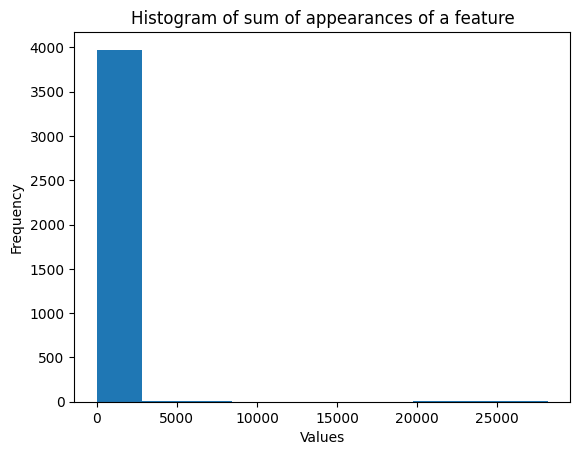

In [ ]:
sum_feats = feature_df.sum().sort_values(ascending=False).to_frame(name='Sum')
# plot a histogram of the sum of features with custom bin size
plt.hist(sum_feats)


# add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of sum of appearances of a feature')

# show the plot
plt.show()

# Taking a balanced subset of the graph

It is an alternative to augmentation technichs since we have a lot of data. Due to computational reasons we want to not work with the whole data on the train and test to begin with.

In [ ]:
# --- Construct a subset graph (balanced) --- use this as train data

nodes_with_labels = nx.get_node_attributes(git_graph, 'label')
nodes_selected = []
ml = 0
web = 0

for node, label in nodes_with_labels.items():
  if label == 1 and ml < 6500:
    ml = ml + 1
    nodes_selected.append(node)
  if label == 0 and web < 6500:
    web = web + 1
    nodes_selected.append(node)
  if ml == 6500 or web == 6500:
    continue
  if ml == 6500 and web == 6500:
    break

G_initial = git_graph.subgraph(nodes_selected)

# Get the rest
rest_of_graph_nodes = set(git_graph.nodes()) - set(G_initial.nodes())
G_rest = git_graph.subgraph(rest_of_graph_nodes)

# get list of nodes with degree 0.
'''if we do that its mostly label one nodes and we are actually missing usefull info we can use I think'''
#nodes_to_remove = [n for n in G_initial.nodes() if G_initial.degree(n) == 0]

G_train = G_initial.copy()

# remove nodes from the graph
#G_train.remove_nodes_from(nodes_to_remove)

# --- Construct a subset graph (balanced) ---
'''
use this as test data, we want the test data to be unbalanced as the original,
which represents reality and there we can test if the model actually generalizes well
The specific numbers can change here the point is to keep a 25%-75% ratio and also be around 30 % of the train data
'''
nodes_with_labels = nx.get_node_attributes(G_rest, 'label')
nodes_selected = []
ml = 0
web = 0

for node, label in nodes_with_labels.items():
  if label == 1 and ml < 1000:
    ml = ml + 1
    nodes_selected.append(node)
  if label == 0 and web < 3000:
    web = web + 1
    nodes_selected.append(node)
  if ml == 1000 or web == 3000:
    continue
  if ml == 1000 and web == 3000:
    break

G_temp = git_graph.subgraph(nodes_selected)

# get list of nodes with degree 0
'''same non-removal reason as above'''
#nodes_to_remove = [n for n in G_temp.nodes() if G_temp.degree(n) == 0]

G_test = G_temp.copy()

# remove nodes from the graph
#G_test.remove_nodes_from(nodes_to_remove)

In [ ]:
# Compute various characteristics of the training graph network
compute_network_characteristics(graph=G_train)

Number of nodes: 13000
Number of edges: 129505
Min. degree: 0
Max. degree: 4008
Mean degree: 19.923846153846153
Median degree: 8.0
Density: 0.0015327214519460077
The type of the graph:  <class 'networkx.classes.graph.Graph'>
The graph is directed:  False


In [ ]:
# Compute various characteristics of the training graph network
compute_network_characteristics(graph=G_test)

Number of nodes: 4000
Number of edges: 3282
Min. degree: 0
Max. degree: 31
Mean degree: 1.641
Median degree: 1.0
Density: 0.0004103525881470368
The type of the graph:  <class 'networkx.classes.graph.Graph'>
The graph is directed:  False


In [ ]:
# Proof that it's balanced

# Get the labels for all nodes in the graph
node_labels = nx.get_node_attributes(G_train, 'label').values()

# Count the occurrences of each label
label_counts = Counter(node_labels)

# Print the label counts
print("Label counts:", label_counts)

print(round(label_counts[1]*100/G_train.number_of_nodes(), 2),'% of the nodes belong to class 1')

Label counts: Counter({1: 6500, 0: 6500})
50.0 % of the nodes belong to class 1


In [ ]:
# Proof that it's unbalanced

# Get the labels for all nodes in the graph
node_labels = nx.get_node_attributes(G_test, 'label').values()

# Count the occurrences of each label
label_counts = Counter(node_labels)

# Print the label counts
print("Label counts:", label_counts)

print(round(label_counts[1]*100/G_test.number_of_nodes(), 2),'% of the nodes belong to class 1')

Label counts: Counter({0: 3000, 1: 1000})
25.0 % of the nodes belong to class 1


# Using Node Information - Getting data ready for modelling

In [ ]:
# Get the ground-truth labels and and the total number of labels
labels_tr = nx.get_node_attributes(G_train, 'label')
labels_tst = nx.get_node_attributes(G_test, 'label')

# PCA on node information

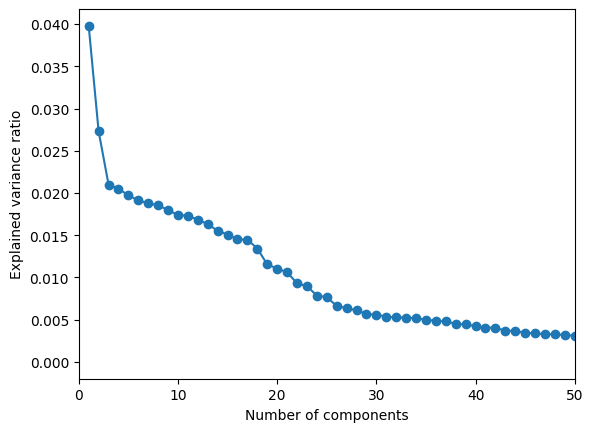

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# fit PCA
pca = PCA().fit(feature_df)

# plot scree plot
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.xlim(0,50)
plt.show()

## roughly 25 components 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def get_pca(node_info,n):
  # perform PCA
  pca = PCA(n_components=n)
  principal_components = pca.fit_transform(node_info)

  # generate new features
  new_features = pd.DataFrame(principal_components)

  return new_features

feature_pca = get_pca(feature_df, 25)

## Without any additional features

In [ ]:
train_features_dict_simple = feature_extractor_simple(nodes = list(G_train.nodes), feature_df=feature_df)
test_features_dict_simple = feature_extractor_simple(nodes = list(G_test.nodes), feature_df=feature_df)


train_features, train_labels, test_features, test_labels = train_test_samples(G_train, G_test, train_features_dict_simple, test_features_dict_simple)

100%|██████████| 4000/4000 [00:04<00:00, 950.33it/s] 


## With PCA

In [ ]:
train_features_dict_simple_pca = feature_extractor_simple(nodes = list(G_train.nodes), feature_df=feature_pca)
test_features_dict_simple_pca = feature_extractor_simple(nodes = list(G_test.nodes), feature_df=feature_pca)


train_features_pca, train_labels_pca, test_features_pca, test_labels_pca = train_test_samples(G_train, G_test, train_features_dict_simple_pca, test_features_dict_simple_pca)

100%|██████████| 4000/4000 [00:01<00:00, 3568.72it/s]


## Adding some features


In [ ]:
'''
Getting greedy modualiarity communities
takes very long to run, thus abandoned and substitute with community coefficient
'''
from networkx.algorithms.community import greedy_modularity_communities
community = greedy_modularity_communities(G_train)

# Converting into list
clusters = []
for group in community:
  clusters.append(list(group))

# Saving each list that represents one cluster into a dictionary with cluster numbers
cluster_nodes = {}
count = 0
for cluster in clusters:
  for c in cluster:
    cluster_nodes[c] = count
  count = count + 1
  

In [ ]:
train_features_dict_extra, test_features_dict_extra = feature_extractor_extra(list(G_train.nodes), list(G_test.nodes), git_graph, feature_df) # This function returns both at the same time in order not to compute centraities twice

train_features_extra, train_labels_extra, test_features_extra, test_labels_extra = train_test_samples(G_train, G_test, train_features_dict_extra, test_features_dict_extra)

100%|██████████| 4000/4000 [00:01<00:00, 2331.03it/s]


In [ ]:
train_features_dict_extra_pca, test_features_dict_extra_pca = feature_extractor_extra(list(G_train.nodes), list(G_test.nodes), git_graph, feature_pca) # This function returns both at the same time in order not to compute centraities twice

train_features_extra_pca, train_labels_extra_pca, test_features_extra_pca, test_labels_extra_pca = train_test_samples(G_train, G_test, train_features_dict_extra_pca, test_features_dict_extra_pca)

100%|██████████| 4000/4000 [00:00<00:00, 14595.61it/s]


# Models

## Logistic Regression

### Using simple features 

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC curve: 


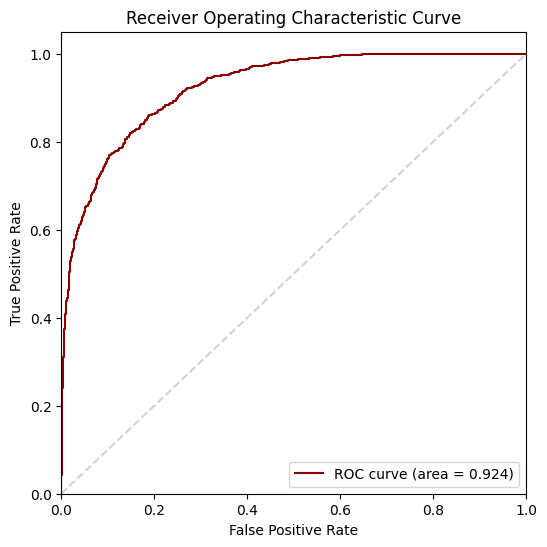

Best Threshold=0.752656, F-Score=0.740


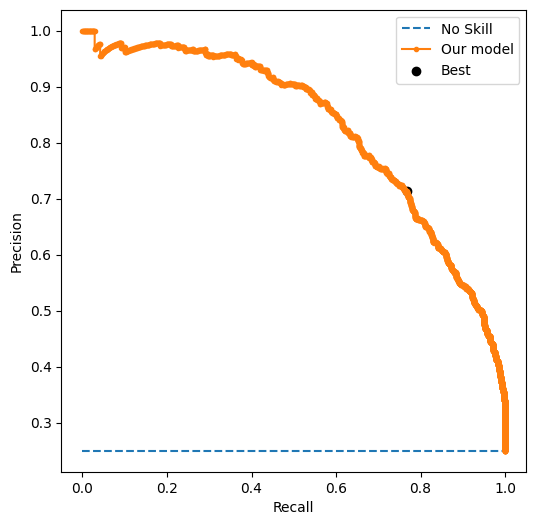

Train accuracy : 0.8957692307692308
Test accuracy : 0.80325
Train f1 : 0.8951319557309806
Test f1 : 0.6905230043255997

Confusion Matrix
[[2335  665]
 [ 122  878]]

               precision    recall  f1-score   support

           0       0.95      0.78      0.86      3000
           1       0.57      0.88      0.69      1000

    accuracy                           0.80      4000
   macro avg       0.76      0.83      0.77      4000
weighted avg       0.86      0.80      0.81      4000



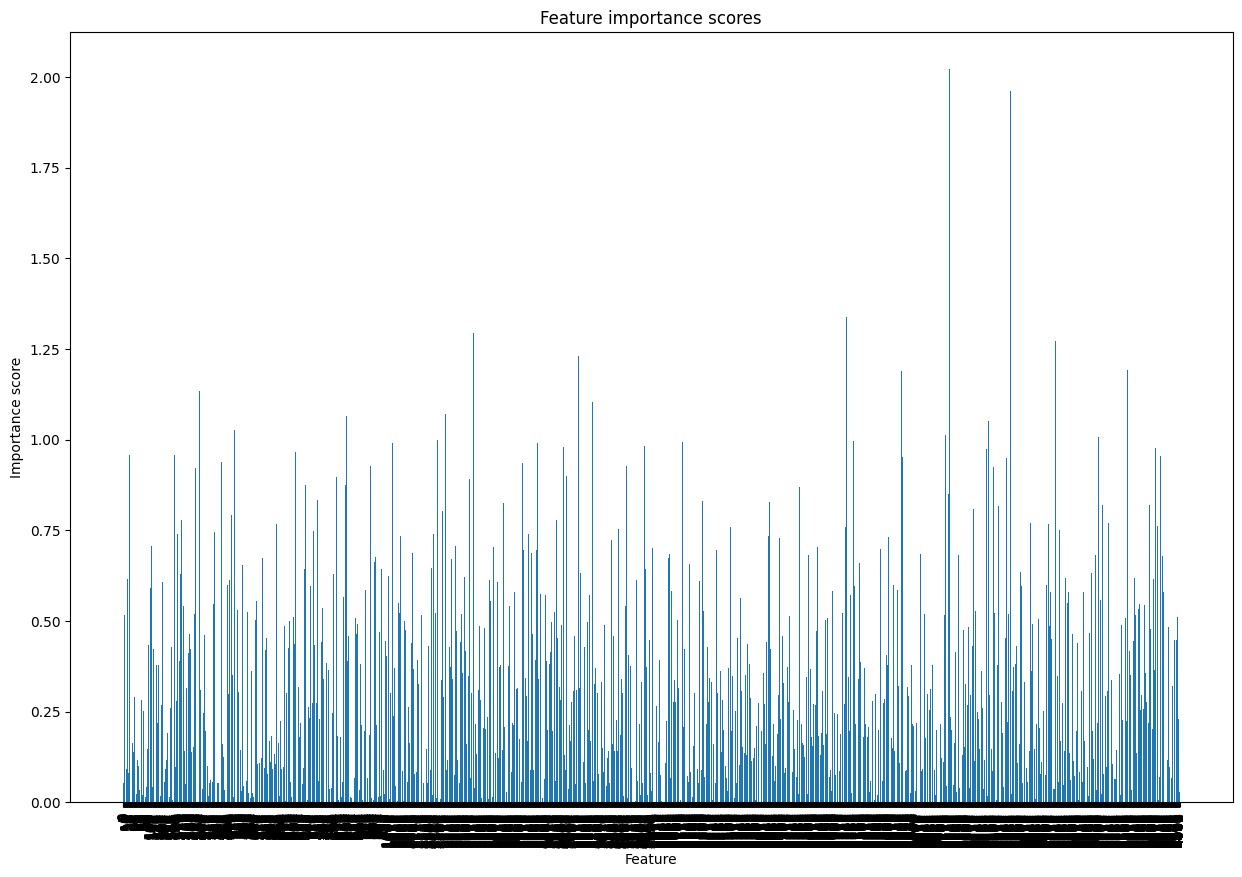

Optimizing Thresholds: 320it [07:56,  1.77s/it]                         


train accuracy best = 0.8666153846153846 with threshold = 0.6990000000000003
test accuracy best = 0.85075 with threshold = 0.6990000000000003

train f1 best = 0.8630629125240205 with threshold = 0.6660000000000003
test f1 score best = 0.7261261261261261 with threshold = 0.6660000000000003

Accuracy score of node classification
0.848

F1 score of node classification
0.7261261261261261

Confusion Matrix
[[2586  414]
 [ 194  806]]

Matrix
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      3000
           1       0.66      0.81      0.73      1000

    accuracy                           0.85      4000
   macro avg       0.80      0.83      0.81      4000
weighted avg       0.86      0.85      0.85      4000



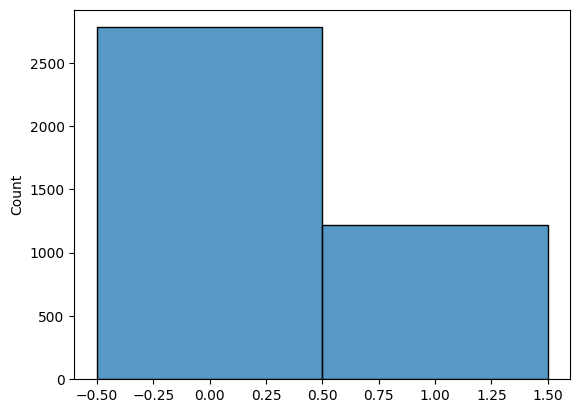

Optimizing Thresholds: 320it [08:07,  1.52s/it]


In [ ]:
lr_clf = LogisticRegression(multi_class='ovr')
roc_auc, test_preds, test_preds_thres = prediction(lr_clf, train_features, train_labels, test_features, test_labels)

### Using PCA

ROC curve: 


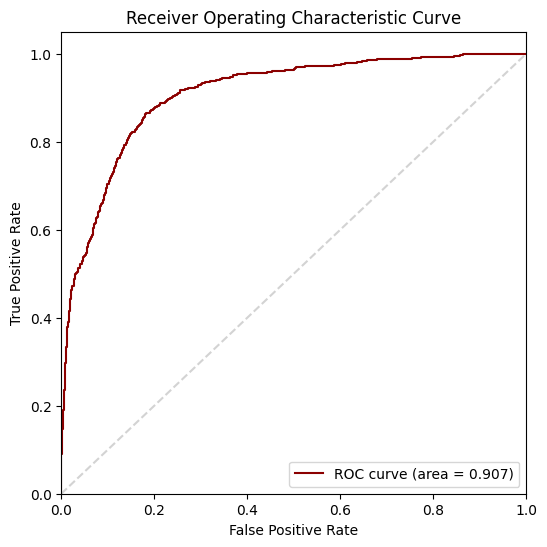

Best Threshold=0.532474, F-Score=0.723


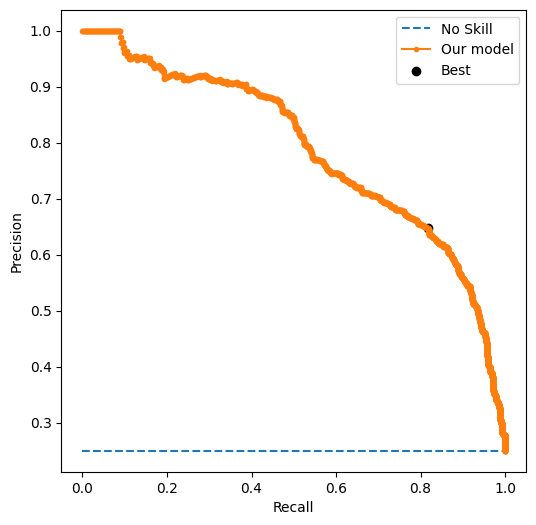

Train accuracy : 0.811076923076923
Test accuracy : 0.83725
Train f1 : 0.8002277533756302
Test f1 : 0.717815344603381

Confusion Matrix
[[2521  479]
 [ 172  828]]

               precision    recall  f1-score   support

           0       0.94      0.84      0.89      3000
           1       0.63      0.83      0.72      1000

    accuracy                           0.84      4000
   macro avg       0.78      0.83      0.80      4000
weighted avg       0.86      0.84      0.84      4000



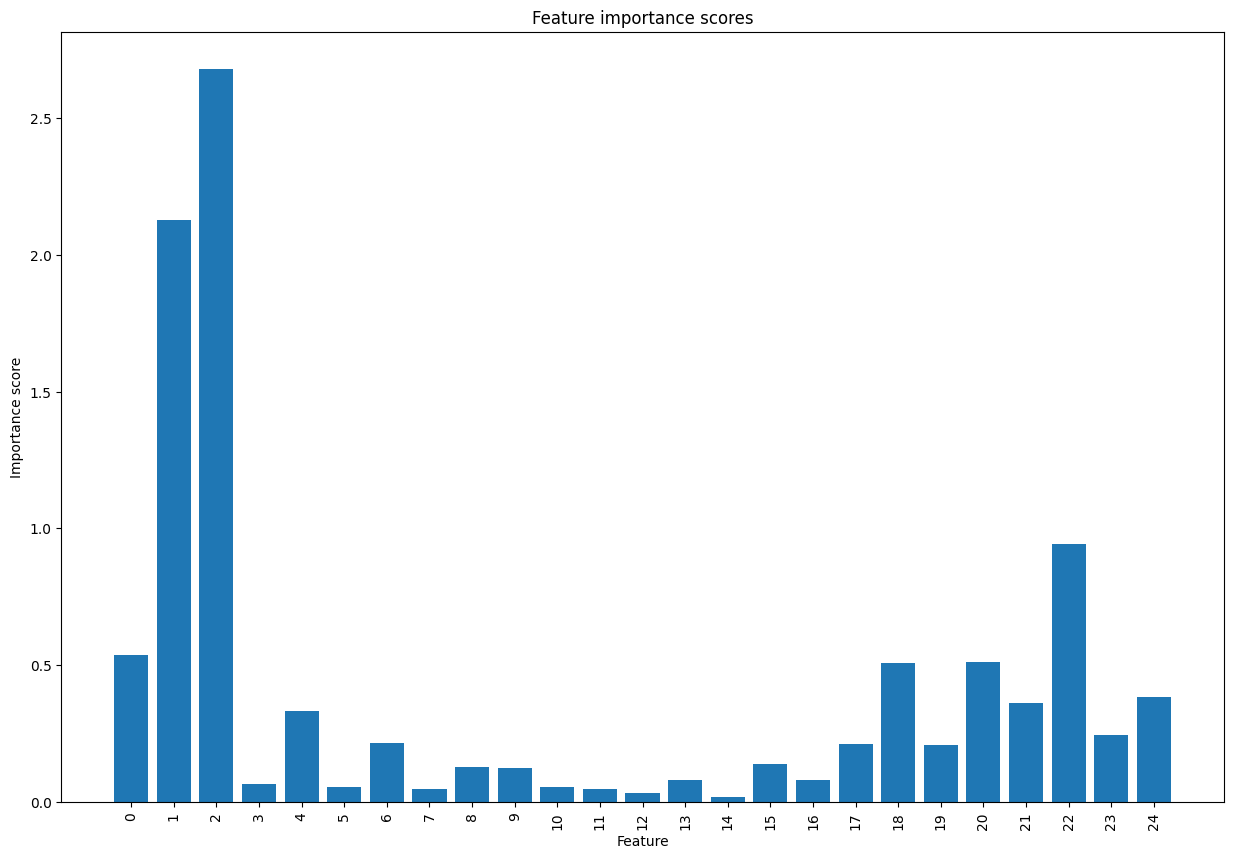

Optimizing Thresholds: 320it [00:11, 37.22it/s]                         


train accuracy best = 0.788 with threshold = 0.6740000000000003
test accuracy best = 0.8515 with threshold = 0.6740000000000003

train f1 best = 0.7955673172345353 with threshold = 0.5330000000000001
test f1 score best = 0.7226890756302521 with threshold = 0.5330000000000001

Accuracy score of node classification
0.84325

F1 score of node classification
0.7226890756302521

Confusion Matrix
[[2556  444]
 [ 183  817]]

Matrix
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      3000
           1       0.65      0.82      0.72      1000

    accuracy                           0.84      4000
   macro avg       0.79      0.83      0.81      4000
weighted avg       0.86      0.84      0.85      4000



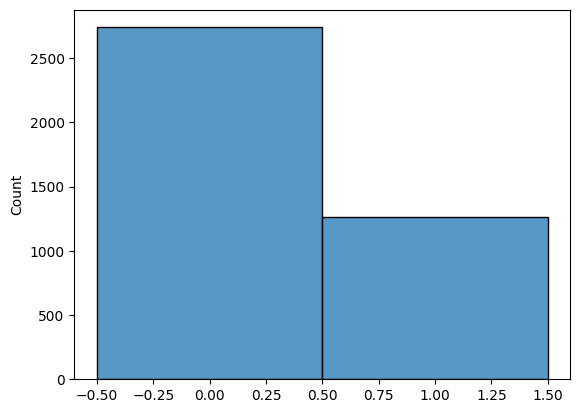

Optimizing Thresholds: 320it [00:12, 26.62it/s]


In [ ]:
lr_clf = LogisticRegression(multi_class='ovr')
roc_auc, test_preds, test_preds_thres = prediction(lr_clf, train_features_pca, train_labels_pca, test_features_pca, test_labels_pca)

### Using extra features

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC curve: 


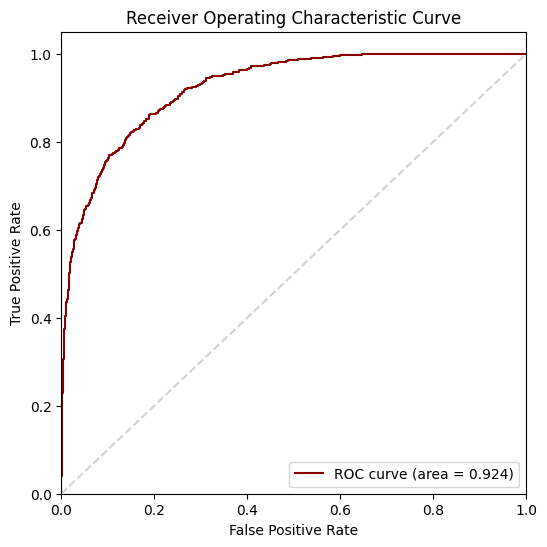

Best Threshold=0.768515, F-Score=0.740


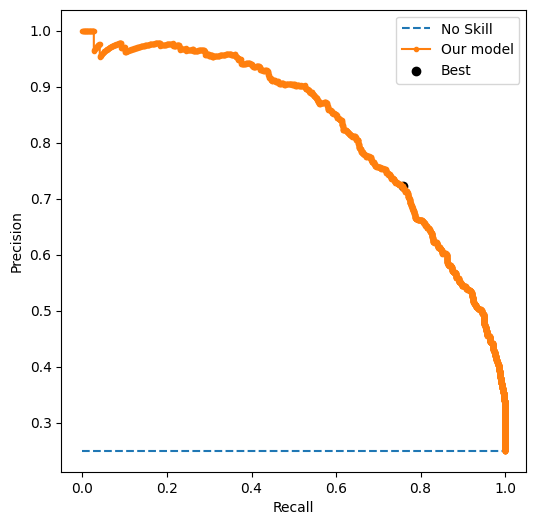

Train accuracy : 0.8959230769230769
Test accuracy : 0.8035
Train f1 : 0.8952705317749052
Test f1 : 0.6905511811023622

Confusion Matrix
[[2337  663]
 [ 123  877]]

               precision    recall  f1-score   support

           0       0.95      0.78      0.86      3000
           1       0.57      0.88      0.69      1000

    accuracy                           0.80      4000
   macro avg       0.76      0.83      0.77      4000
weighted avg       0.85      0.80      0.81      4000



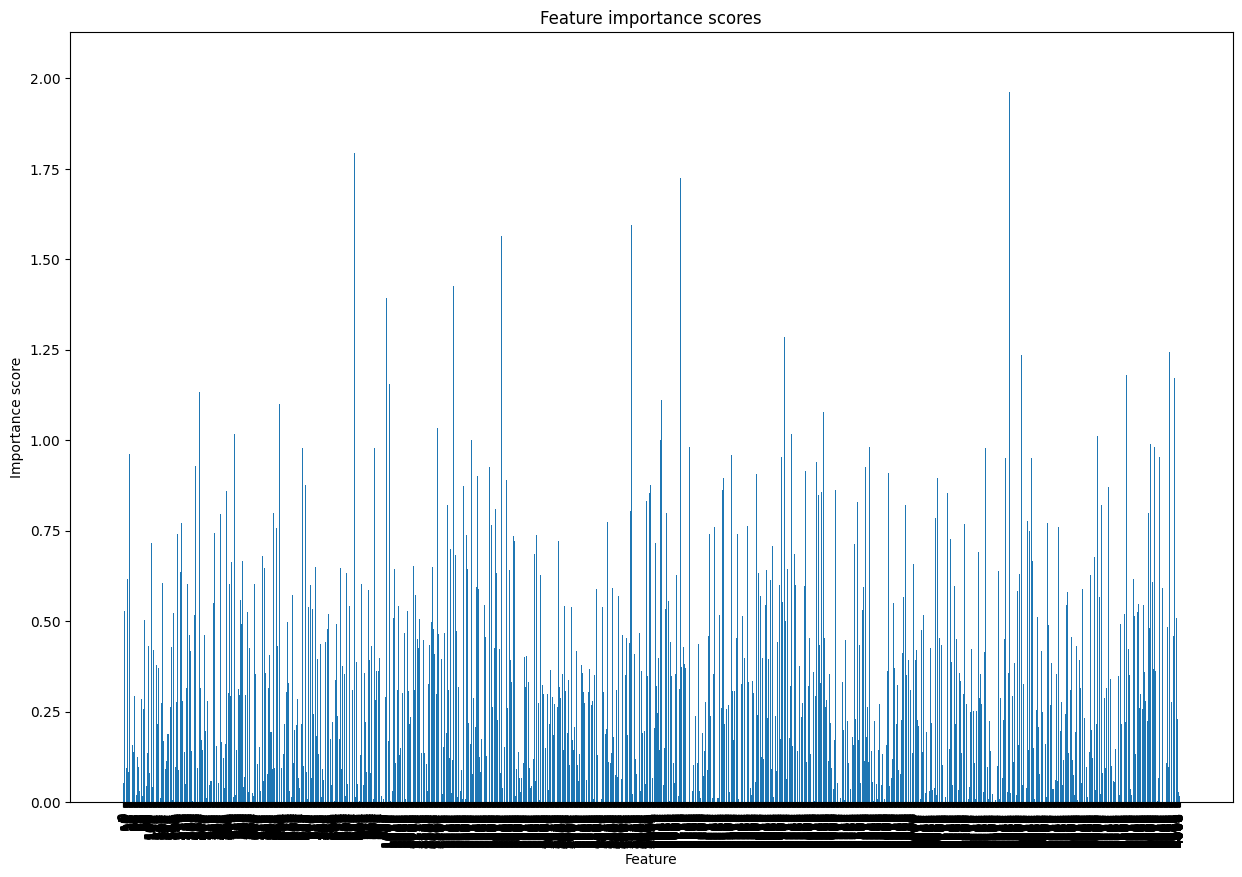

Optimizing Thresholds:  16%|█▋        | 52/319 [01:39<09:25,  2.12s/it]

In [ ]:
lr_clf = LogisticRegression(multi_class='ovr')
roc_auc, test_preds, test_preds_thres = prediction(lr_clf, train_features_extra, train_labels_extra, test_features_extra, test_labels_extra)

ROC curve: 


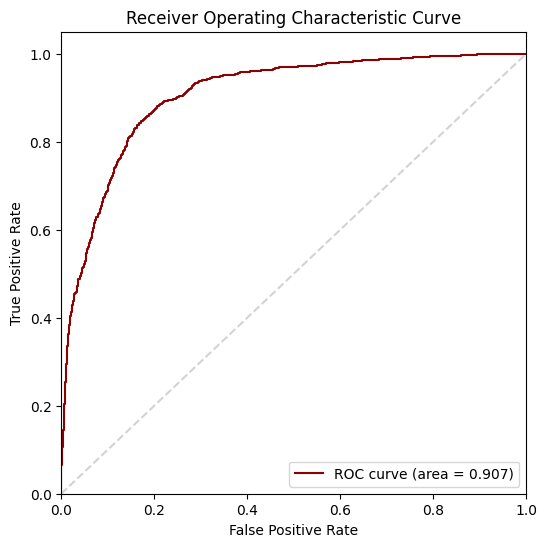

Best Threshold=0.564137, F-Score=0.722


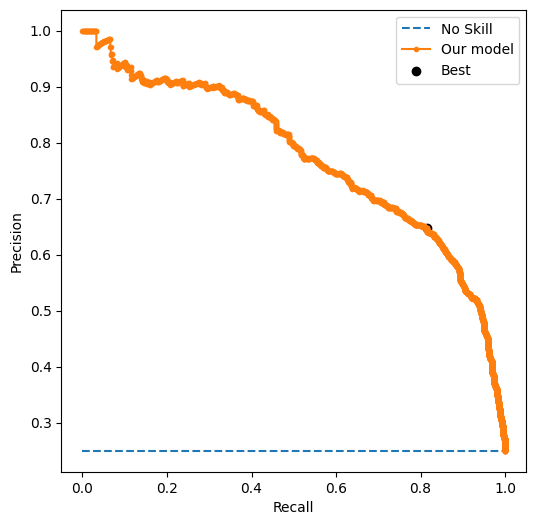

Train accuracy : 0.8156923076923077
Test accuracy : 0.82725
Train f1 : 0.8072095268747989
Test f1 : 0.7126819126819127

Confusion Matrix
[[2452  548]
 [ 143  857]]

               precision    recall  f1-score   support

           0       0.94      0.82      0.88      3000
           1       0.61      0.86      0.71      1000

    accuracy                           0.83      4000
   macro avg       0.78      0.84      0.79      4000
weighted avg       0.86      0.83      0.84      4000



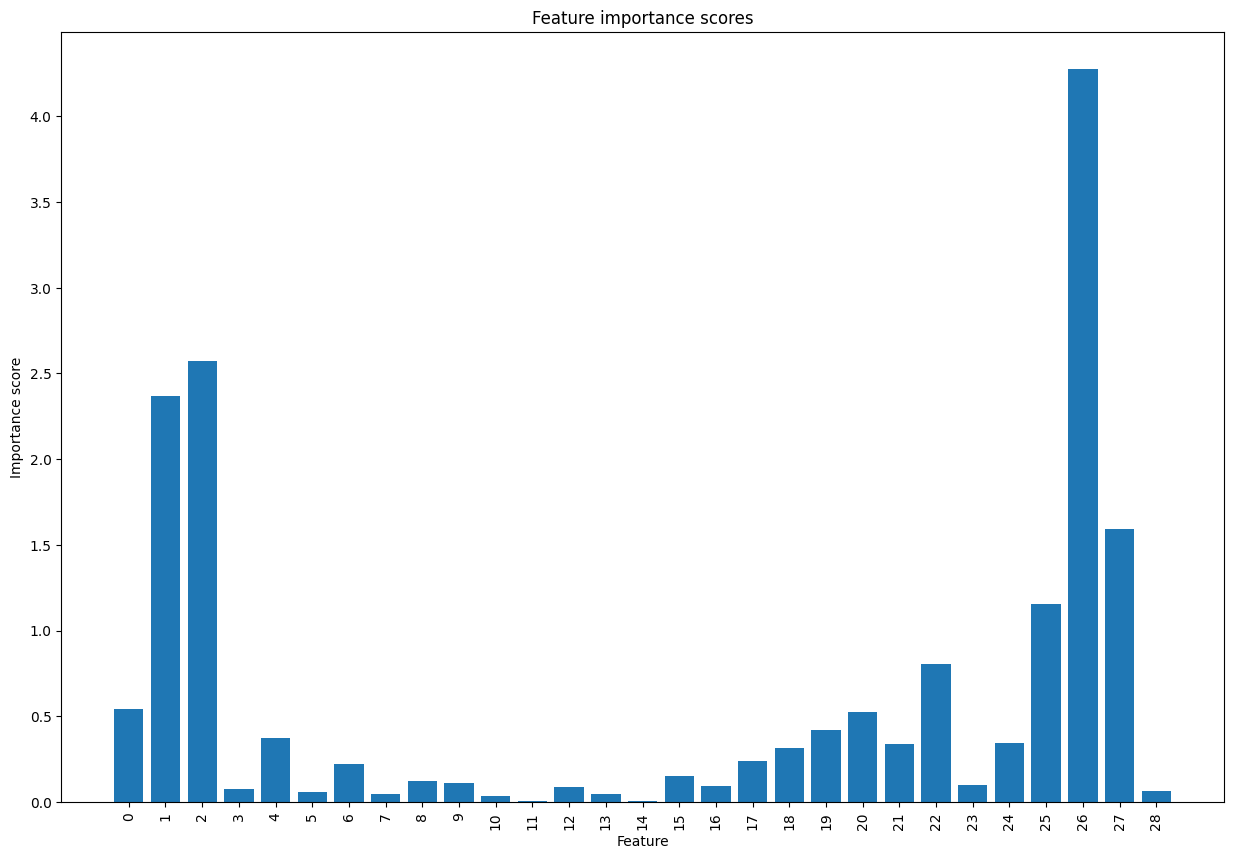

Optimizing Thresholds: 100%|██████████| 319/319 [00:13<00:00, 19.35it/s]


train accuracy best = 0.791 with threshold = 0.6820000000000003
test accuracy best = 0.84975 with threshold = 0.6820000000000003

train f1 best = 0.7944430579818651 with threshold = 0.5640000000000002
test f1 score best = 0.721951219512195 with threshold = 0.5640000000000002

Accuracy score of node classification
0.84325

F1 score of node classification
0.721951219512195

Confusion Matrix
[[2559  441]
 [ 186  814]]

Matrix
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      3000
           1       0.65      0.81      0.72      1000

    accuracy                           0.84      4000
   macro avg       0.79      0.83      0.81      4000
weighted avg       0.86      0.84      0.85      4000



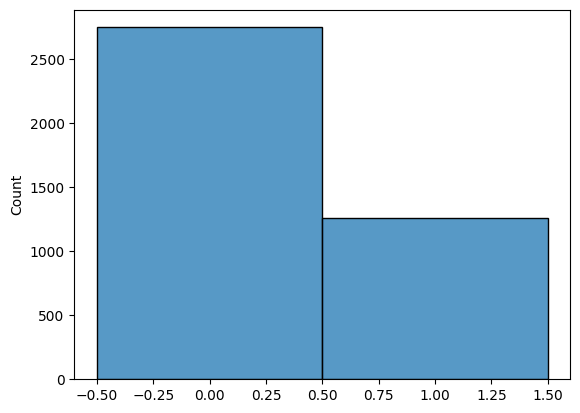

Optimizing Thresholds: 320it [00:14, 21.90it/s]                         


In [ ]:
# PCA with extra features
lr_clf = LogisticRegression(multi_class='ovr')
roc_auc, test_preds, test_preds_thres = prediction(lr_clf, train_features_extra_pca, train_labels_extra_pca, test_features_extra_pca, test_labels_extra_pca)

### Grid Search

In [ ]:
# Define parameter grid
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.01, 0.1, 1, 10, 100],
              #'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
              'max_iter': [100, 500, 1000]
              }

grid_search(param_grid, lr_clf, train_features, train_labels)

## Random Forest

ROC curve: 


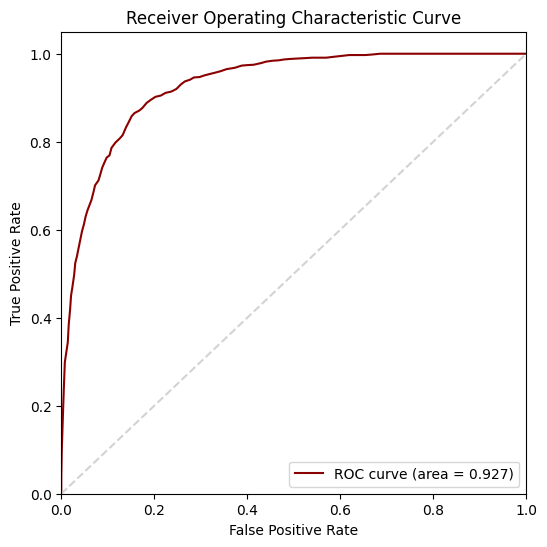

Best Threshold=0.710000, F-Score=0.745


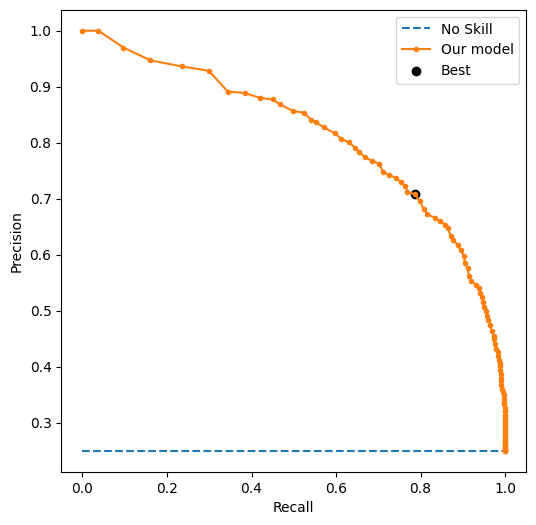

Train accuracy : 1.0
Test accuracy : 0.77275
Train f1 : 1.0
Test f1 : 0.6754730453409497

Confusion Matrix
[[2145  855]
 [  54  946]]

               precision    recall  f1-score   support

           0       0.98      0.71      0.83      3000
           1       0.53      0.95      0.68      1000

    accuracy                           0.77      4000
   macro avg       0.75      0.83      0.75      4000
weighted avg       0.86      0.77      0.79      4000



Optimizing Thresholds: 320it [08:09,  1.44s/it]                         


train accuracy best = 0.9838461538461538 with threshold = 0.6990000000000003
test accuracy best = 0.86225 with threshold = 0.6990000000000003

train f1 best = 0.983580922595778 with threshold = 0.6990000000000003
test f1 score best = 0.7433628318584071 with threshold = 0.6990000000000003

Accuracy score of node classification
0.86225

F1 score of node classification
0.7433628318584071

Confusion Matrix
[[2651  349]
 [ 202  798]]

Matrix
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      3000
           1       0.70      0.80      0.74      1000

    accuracy                           0.86      4000
   macro avg       0.81      0.84      0.82      4000
weighted avg       0.87      0.86      0.87      4000



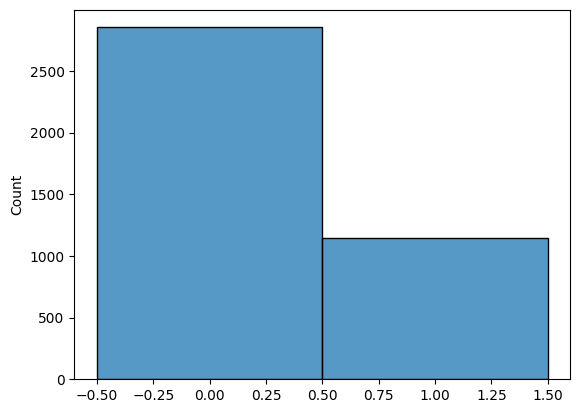

Optimizing Thresholds: 320it [08:21,  1.57s/it]


In [ ]:
rf_clf = RandomForestClassifier()
roc_auc, test_preds, test_preds_thres = prediction(rf_clf, train_features, train_labels, test_features, test_labels)

ROC curve: 


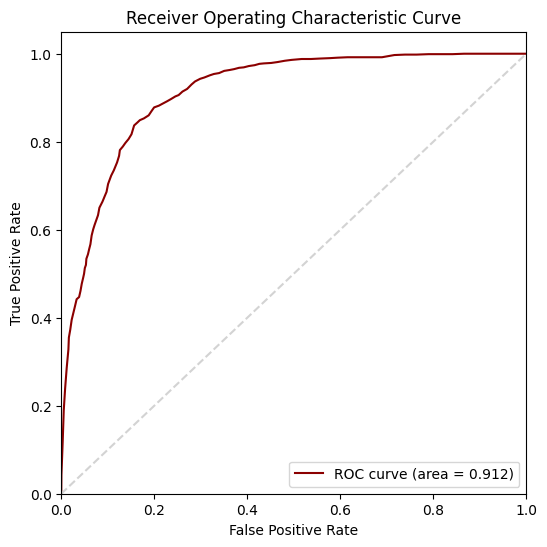

Best Threshold=0.580000, F-Score=0.726


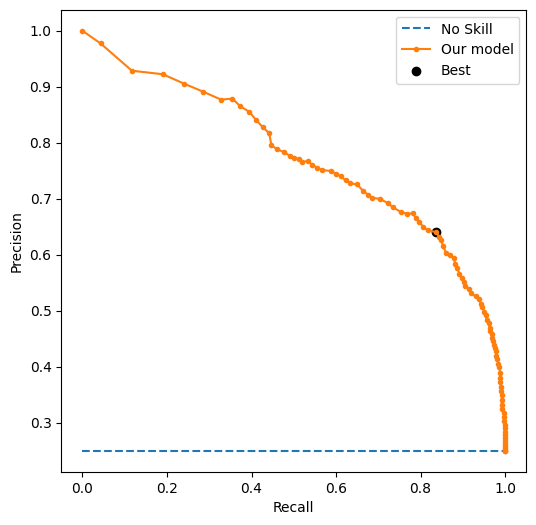

Train accuracy : 1.0
Test accuracy : 0.813
Train f1 : 1.0
Test f1 : 0.7022292993630574

Confusion Matrix
[[2370  630]
 [ 118  882]]

               precision    recall  f1-score   support

           0       0.95      0.79      0.86      3000
           1       0.58      0.88      0.70      1000

    accuracy                           0.81      4000
   macro avg       0.77      0.84      0.78      4000
weighted avg       0.86      0.81      0.82      4000




Optimizing Thresholds: 100%|██████████| 319/319 [00:27<00:00,  9.93it/s]
Optimizing Thresholds: 320it [00:27,  9.65it/s]                         


train accuracy best = 0.9958461538461538 with threshold = 0.6290000000000002
test accuracy best = 0.85075 with threshold = 0.6290000000000002

train f1 best = 0.9995382484223488 with threshold = 0.5790000000000002
test f1 score best = 0.7256176853055918 with threshold = 0.5790000000000002

Accuracy score of node classification
0.84175

F1 score of node classification
0.7256176853055918

Confusion Matrix
[[2530  470]
 [ 163  837]]

Matrix
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      3000
           1       0.64      0.84      0.73      1000

    accuracy                           0.84      4000
   macro avg       0.79      0.84      0.81      4000
weighted avg       0.86      0.84      0.85      4000



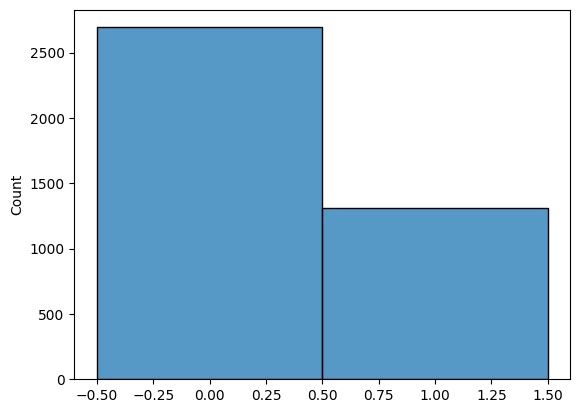

Optimizing Thresholds: 320it [00:28, 11.24it/s]


In [ ]:
# Same model with PCA
rf_clf = RandomForestClassifier()
roc_auc, test_preds, test_preds_thres = prediction(rf_clf, train_features_pca, train_labels_pca, test_features_pca, test_labels_pca)

ROC curve: 


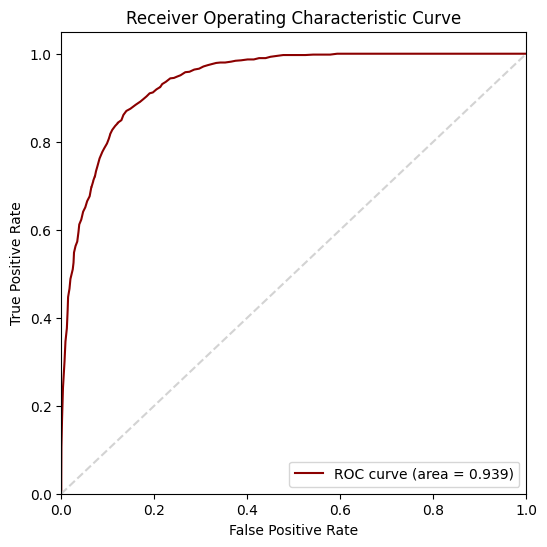

Best Threshold=0.660000, F-Score=0.767


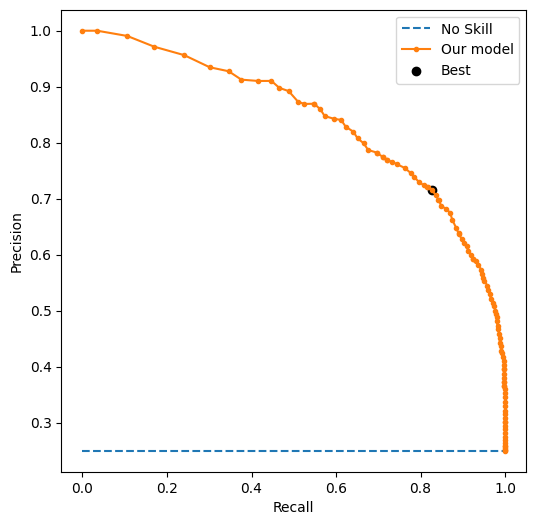

Train accuracy : 1.0
Test accuracy : 0.82
Train f1 : 1.0
Test f1 : 0.7211463981409759

Confusion Matrix
[[2349  651]
 [  69  931]]

               precision    recall  f1-score   support

           0       0.97      0.78      0.87      3000
           1       0.59      0.93      0.72      1000

    accuracy                           0.82      4000
   macro avg       0.78      0.86      0.79      4000
weighted avg       0.88      0.82      0.83      4000



Optimizing Thresholds: 320it [07:49,  1.30s/it]                         


train accuracy best = 0.985 with threshold = 0.6990000000000003
test accuracy best = 0.877 with threshold = 0.6990000000000003

train f1 best = 0.9942751044406621 with threshold = 0.6590000000000003
test f1 score best = 0.7671614100185529 with threshold = 0.6590000000000003

Accuracy score of node classification
0.8745

F1 score of node classification
0.7671614100185529

Confusion Matrix
[[2671  329]
 [ 173  827]]

Matrix
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      3000
           1       0.72      0.83      0.77      1000

    accuracy                           0.87      4000
   macro avg       0.83      0.86      0.84      4000
weighted avg       0.88      0.87      0.88      4000



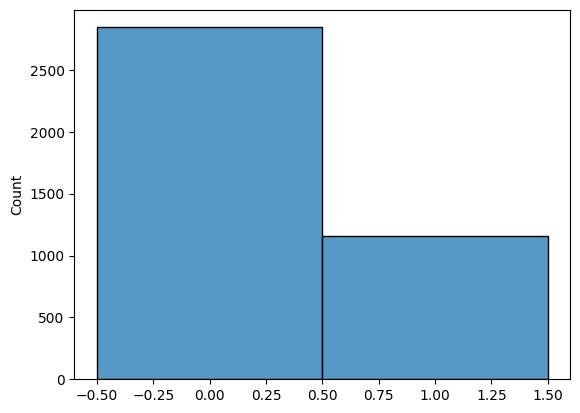

Optimizing Thresholds: 320it [07:59,  1.50s/it]


In [ ]:
# Same model with extra features
rf_clf = RandomForestClassifier()
roc_auc, test_preds, test_preds_thres = prediction(rf_clf, train_features_extra, train_labels_extra, test_features_extra, test_labels_extra)

ROC curve: 


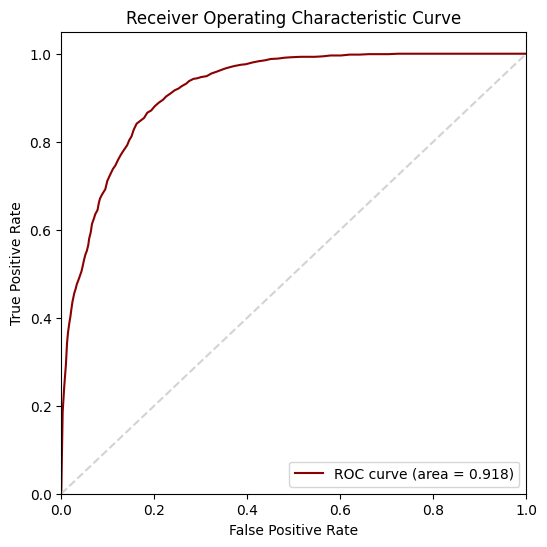

Best Threshold=0.590000, F-Score=0.723


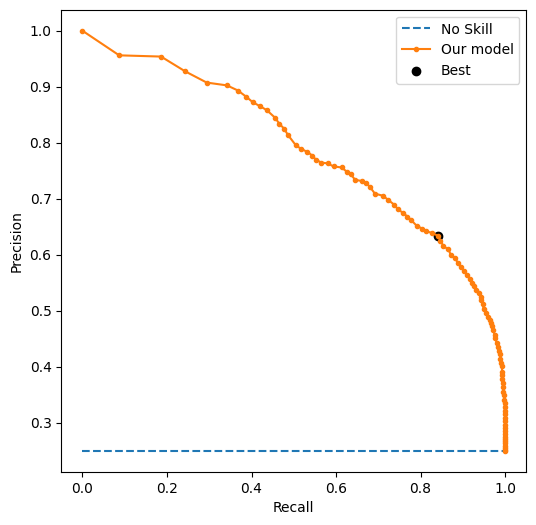

Train accuracy : 1.0
Test accuracy : 0.8065
Train f1 : 1.0
Test f1 : 0.7000000000000001

Confusion Matrix
[[2323  677]
 [  97  903]]

               precision    recall  f1-score   support

           0       0.96      0.77      0.86      3000
           1       0.57      0.90      0.70      1000

    accuracy                           0.81      4000
   macro avg       0.77      0.84      0.78      4000
weighted avg       0.86      0.81      0.82      4000



Optimizing Thresholds: 320it [00:56,  7.06it/s]                         


train accuracy best = 0.9817692307692307 with threshold = 0.6990000000000003
test accuracy best = 0.8535 with threshold = 0.6990000000000003

train f1 best = 0.9993072126857055 with threshold = 0.5890000000000002
test f1 score best = 0.7228190803609797 with threshold = 0.5890000000000002

Accuracy score of node classification
0.83875

F1 score of node classification
0.7228190803609797

Confusion Matrix
[[2514  486]
 [ 159  841]]

Matrix
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      3000
           1       0.63      0.84      0.72      1000

    accuracy                           0.84      4000
   macro avg       0.79      0.84      0.80      4000
weighted avg       0.86      0.84      0.85      4000



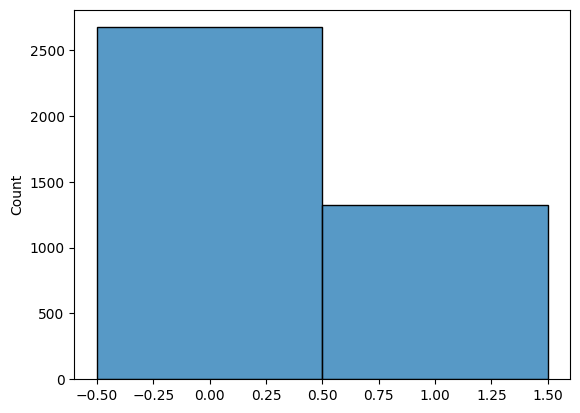

Optimizing Thresholds: 320it [00:57,  5.59it/s]


In [ ]:
# PCA with extra features
rf_clf = RandomForestClassifier()
roc_auc, test_preds, test_preds_thres = prediction(rf_clf, train_features_extra_pca, train_labels_extra_pca, test_features_extra_pca, test_labels_extra_pca)

### Grid Search

In [ ]:
# Define parameter grid
param_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [None, 5, 10],
              'max_features': ['sqrt', 'log2', None]
              }


grid_search(param_grid, rf_clf, train_features, train_labels)

## XGBoost

ROC curve: 


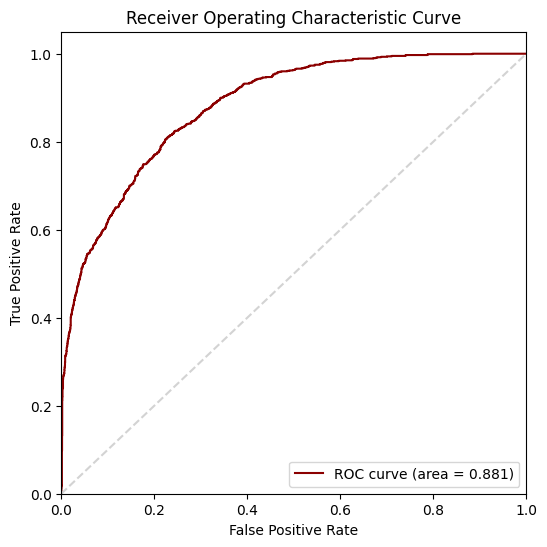

Best Threshold=0.973972, F-Score=0.658


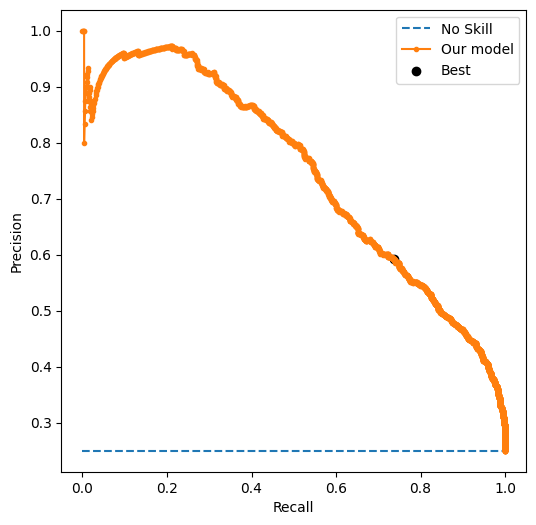

Train accuracy : 0.9005384615384615
Test accuracy : 0.6435
Train f1 : 0.9002545707012266
Test f1 : 0.5725419664268585

Confusion Matrix
[[1619 1381]
 [  45  955]]

               precision    recall  f1-score   support

           0       0.97      0.54      0.69      3000
           1       0.41      0.95      0.57      1000

    accuracy                           0.64      4000
   macro avg       0.69      0.75      0.63      4000
weighted avg       0.83      0.64      0.66      4000



Optimizing Thresholds: 320it [12:35,  2.26s/it]                         


train accuracy best = 0.8741538461538462 with threshold = 0.6980000000000003
test accuracy best = 0.705 with threshold = 0.6980000000000003

train f1 best = 0.8611441181463247 with threshold = 0.6980000000000003
test f1 score best = 0.6066666666666667 with threshold = 0.6980000000000003

Accuracy score of node classification
0.705

F1 score of node classification
0.6066666666666667

Confusion Matrix
[[1910 1090]
 [  90  910]]

Matrix
              precision    recall  f1-score   support

           0       0.95      0.64      0.76      3000
           1       0.46      0.91      0.61      1000

    accuracy                           0.70      4000
   macro avg       0.70      0.77      0.69      4000
weighted avg       0.83      0.70      0.72      4000



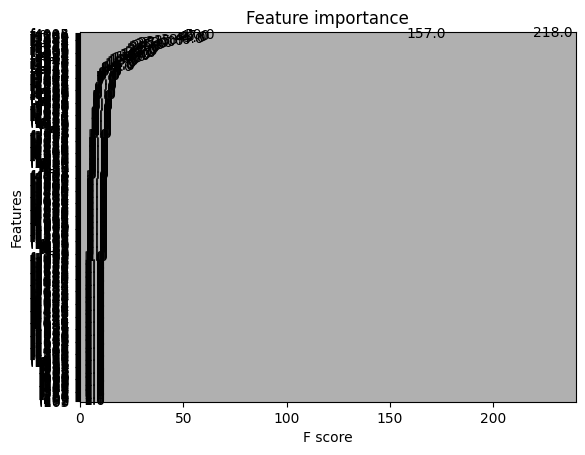

Optimizing Thresholds: 320it [12:58,  2.43s/it]


In [ ]:
xgb_clf = XGBClassifier()
roc_auc, test_preds, test_preds_thres = prediction(xgb_clf, train_features, train_labels, test_features, test_labels)

ROC curve: 


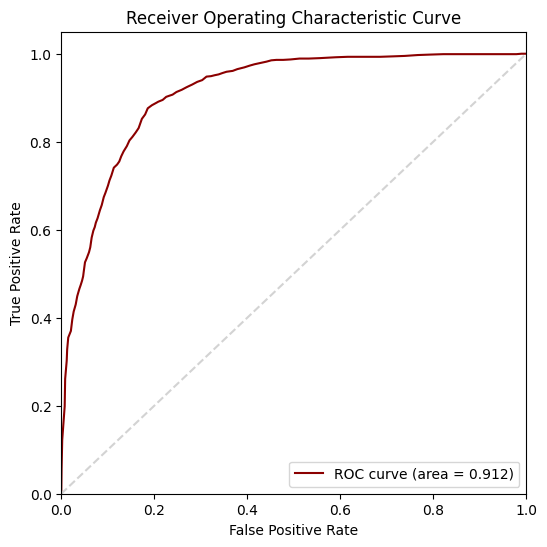

Best Threshold=0.540000, F-Score=0.720


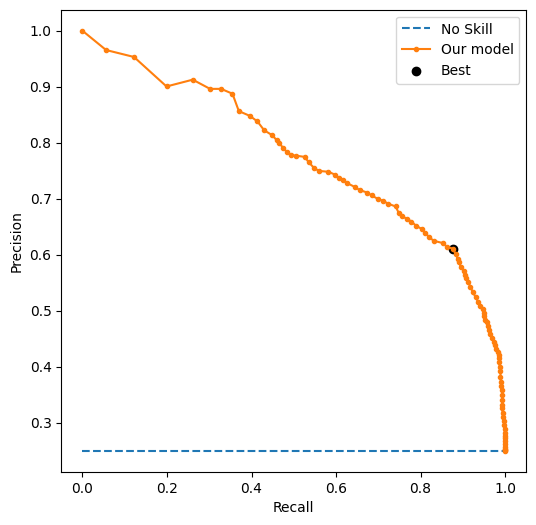

Train accuracy : 1.0
Test accuracy : 0.81625
Train f1 : 1.0
Test f1 : 0.7079856972586412

Confusion Matrix
[[2374  626]
 [ 109  891]]

               precision    recall  f1-score   support

           0       0.96      0.79      0.87      3000
           1       0.59      0.89      0.71      1000

    accuracy                           0.82      4000
   macro avg       0.77      0.84      0.79      4000
weighted avg       0.86      0.82      0.83      4000




Optimizing Thresholds: 100%|█████████▉| 318/319 [00:27<00:00, 12.18it/s]
Optimizing Thresholds: 320it [00:27, 12.19it/s]                         


train accuracy best = 0.991 with threshold = 0.6590000000000003
test accuracy best = 0.8505 with threshold = 0.6590000000000003

train f1 best = 1.0 with threshold = 0.5390000000000001
test f1 score best = 0.7198027937551356 with threshold = 0.5390000000000001

Accuracy score of node classification
0.8295

F1 score of node classification
0.7198027937551356

Confusion Matrix
[[2442  558]
 [ 124  876]]

Matrix
              precision    recall  f1-score   support

           0       0.95      0.81      0.88      3000
           1       0.61      0.88      0.72      1000

    accuracy                           0.83      4000
   macro avg       0.78      0.84      0.80      4000
weighted avg       0.87      0.83      0.84      4000



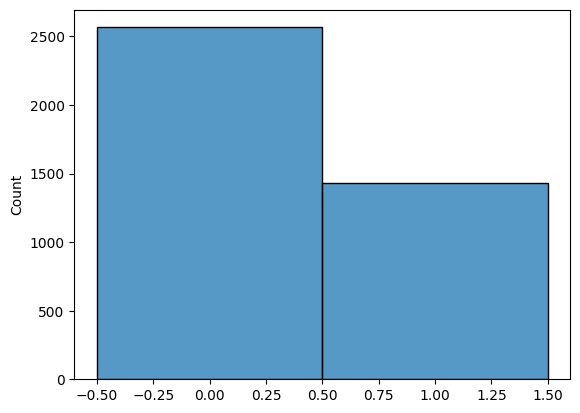

Optimizing Thresholds: 320it [00:28, 11.17it/s]


In [ ]:
# Same model with PCA
xgb_clf = XGBClassifier()
roc_auc, test_preds, test_preds_thres = prediction(rf_clf, train_features_pca, train_labels_pca, test_features_pca, test_labels_pca)

ROC curve: 


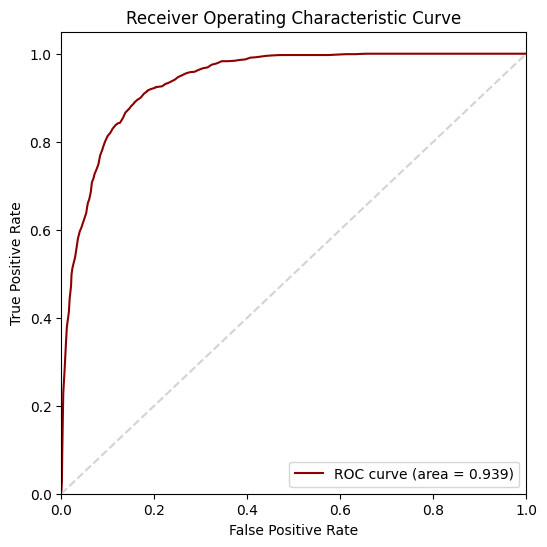

Best Threshold=0.680000, F-Score=0.770


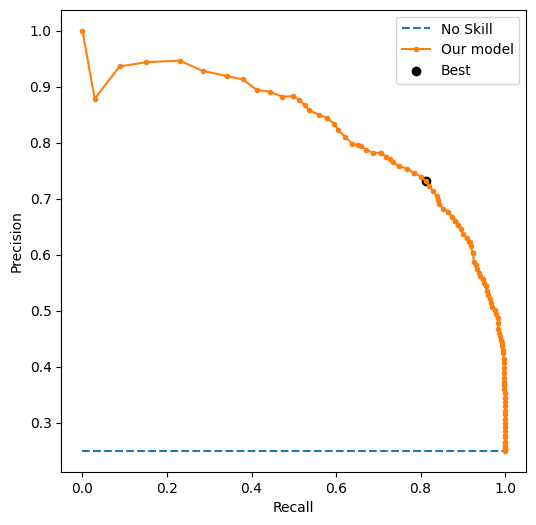

Train accuracy : 1.0
Test accuracy : 0.81875
Train f1 : 1.0
Test f1 : 0.7186651144741948

Confusion Matrix
[[2349  651]
 [  74  926]]

               precision    recall  f1-score   support

           0       0.97      0.78      0.87      3000
           1       0.59      0.93      0.72      1000

    accuracy                           0.82      4000
   macro avg       0.78      0.85      0.79      4000
weighted avg       0.87      0.82      0.83      4000



Optimizing Thresholds: 320it [07:51,  1.30s/it]                         


train accuracy best = 0.985 with threshold = 0.6920000000000003
test accuracy best = 0.8795 with threshold = 0.6920000000000003

train f1 best = 0.9901343898081255 with threshold = 0.6790000000000003
test f1 score best = 0.7698863636363636 with threshold = 0.6790000000000003

Accuracy score of node classification
0.8785

F1 score of node classification
0.7698863636363636

Confusion Matrix
[[2701  299]
 [ 187  813]]

Matrix
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3000
           1       0.73      0.81      0.77      1000

    accuracy                           0.88      4000
   macro avg       0.83      0.86      0.84      4000
weighted avg       0.88      0.88      0.88      4000



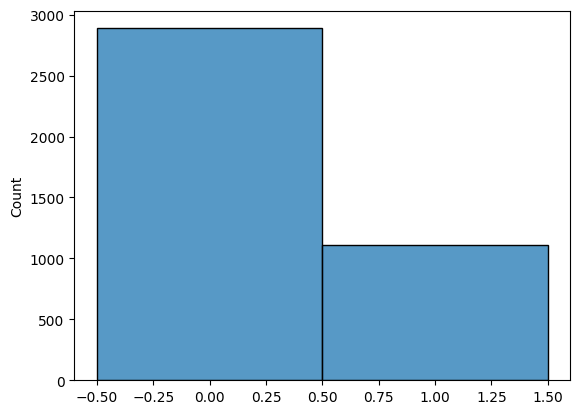

Optimizing Thresholds: 320it [08:02,  1.51s/it]


In [ ]:
# Same model with extra features
xgb_clf = XGBClassifier()
roc_auc, test_preds, test_preds_thres = prediction(rf_clf, train_features_extra, train_labels_extra, test_features_extra, test_labels_extra)

ROC curve: 


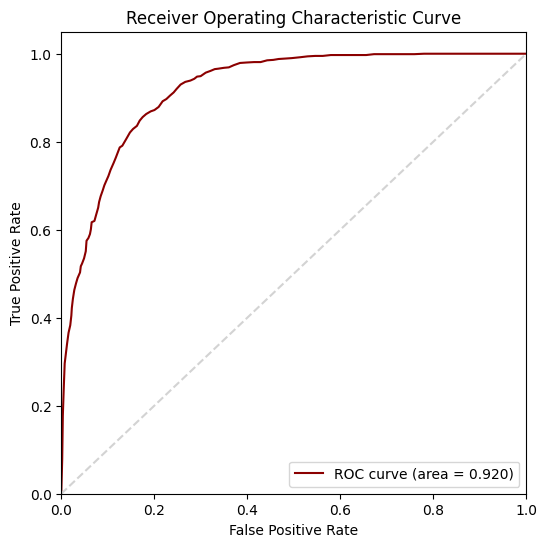

Best Threshold=0.640000, F-Score=0.727


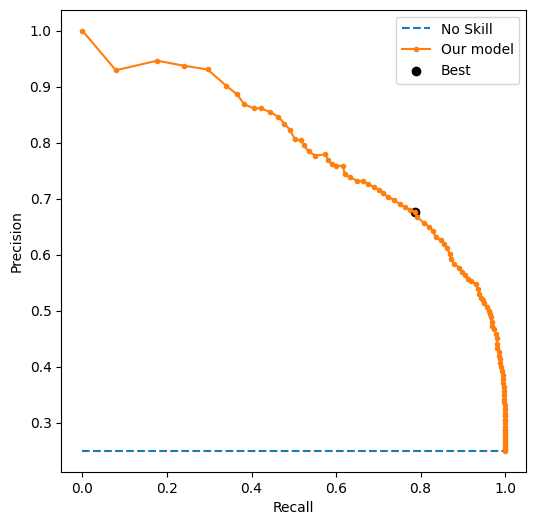

Train accuracy : 0.9999230769230769
Test accuracy : 0.80475
Train f1 : 0.9999230828397815
Test f1 : 0.6966990291262136

Confusion Matrix
[[2322  678]
 [ 103  897]]

               precision    recall  f1-score   support

           0       0.96      0.77      0.86      3000
           1       0.57      0.90      0.70      1000

    accuracy                           0.80      4000
   macro avg       0.76      0.84      0.78      4000
weighted avg       0.86      0.80      0.82      4000



Optimizing Thresholds: 320it [00:40,  8.42it/s]                         


train accuracy best = 0.9820769230769231 with threshold = 0.6990000000000003
test accuracy best = 0.85525 with threshold = 0.6990000000000003

train f1 best = 0.9958288274370461 with threshold = 0.6390000000000002
test f1 score best = 0.7273567467652495 with threshold = 0.6390000000000002

Accuracy score of node classification
0.8525

F1 score of node classification
0.7273567467652495

Confusion Matrix
[[2623  377]
 [ 213  787]]

Matrix
              precision    recall  f1-score   support

           0       0.92      0.87      0.90      3000
           1       0.68      0.79      0.73      1000

    accuracy                           0.85      4000
   macro avg       0.80      0.83      0.81      4000
weighted avg       0.86      0.85      0.86      4000



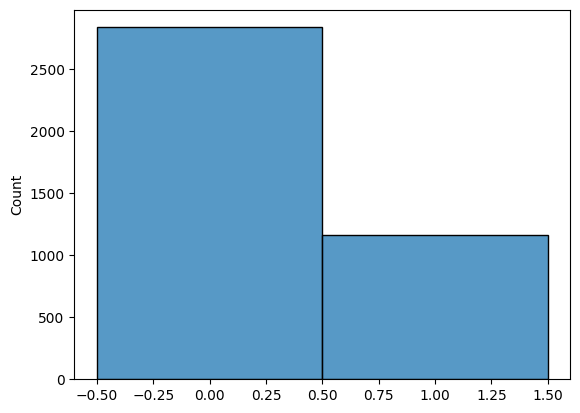

Optimizing Thresholds: 320it [00:41,  7.63it/s]


In [ ]:
# PCA with extra features
xgb_clf = XGBClassifier()
roc_auc, test_preds, test_preds_thres = prediction(rf_clf, train_features_extra_pca, train_labels_extra_pca, test_features_extra_pca, test_labels_extra_pca)

### Grid Search

In [ ]:
# Define parameter grid
param_grid = {'learning_rate': [0.01, 0.1, 0.5],
              'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 7]
              }

grid_search(param_grid, xgb_clf, train_features, train_labels)

# Deepwalk + Word2Vec (SkipGram) 

In [ ]:
# Define parameters
num_of_walks = 300
walk_length = 8
embedding_size = 32
window_size = 6
output_filename="./graph.wordembedding"

# Perform random walks
walks = deep_walk(graph=git_graph, N=num_of_walks, L=walk_length)
# Learn representations of nodes
model = Word2Vec(walks, vector_size=embedding_size, window=window_size, min_count=0, workers=3, sg=1, hs=1, negative=0)
# Save the embedding vectors
model.wv.save_word2vec_format(output_filename)

In [ ]:
train_emb_dict_simple = feature_extractor_simple(list(G_train.nodes), model)
test_emb_dict_simple = feature_extractor_simple(list(G_test.nodes), model)

train_features, train_labels, test_features, test_labels = train_test_samples(G_train, G_test, train_emb_dict_simple, test_emb_dict_simple)

lr_clf = LogisticRegression(multi_class='ovr') # maybe try other types of models
roc_auc, test_preds, test_preds_thres = prediction(lr_clf, train_features_extra, train_labels_extra, test_features_extra, test_labels_extra)

Accuracy score of node classification


0.6337254901960784

# Node2Vec

In [ ]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(git_graph, dimensions=32, walk_length=8, num_walks=200, workers=1, p=1, q=1)

# Embed nodes
model = node2vec.fit(window=5, min_count=1, batch_words=4)

# Save
model.wv.save_word2vec_format('Node2Vec_emb')

Computing transition probabilities:   0%|          | 0/37700 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [45:19<00:00, 13.60s/it]


In [ ]:
train_emb_dict_simple = feature_extractor_simple(list(G_train.nodes), model)
test_emb_dict_simple = feature_extractor_simple(list(G_test.nodes), model)

train_features, train_labels, test_features, test_labels = train_test_samples(G_train, G_test, train_emb_dict_simple, test_emb_dict_simple)

lr_clf = LogisticRegression(multi_class='ovr') # maybe try other types of models
roc_auc, test_preds, test_preds_thres = prediction(lr_clf, train_features_extra, train_labels_extra, test_features_extra, test_labels_extra)

Accuracy score of node classification
0.8209150326797385
Confusion Matrix
[[1682  272]
 [ 413 1458]]
Matrix
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1954
           1       0.84      0.78      0.81      1871

    accuracy                           0.82      3825
   macro avg       0.82      0.82      0.82      3825
weighted avg       0.82      0.82      0.82      3825



# Graph Convolutional Network

### Converting the NetworkX graph into a DGL Graph

In [ ]:
!pip install dgl
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 19.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [ ]:
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

# from torch_geometric.data import Data
# from torch_geometric.transforms import AddTrainValTestMask as masking
# from torch_geometric.utils.convert import to_networkx
# from torch_geometric.nn import GCNConv

import networkx as nx

In [ ]:
# Import packages
import dgl
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
from IPython.display import Latex
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from node2vec import Node2Vec

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
G_dgl = dgl.from_networkx(git_graph)

In [ ]:
# Verifying graph characteristics
print("The number of nodes in the graph: ", G_dgl.num_nodes())
print("The number of edges in the graph: ", G_dgl.num_edges())
print("The type of the graph: ", type(G_dgl))

# Generates a bi-directional graph with directed edges in each direction between 2 nodes

The number of nodes in the graph:  37700
The number of edges in the graph:  578006
The type of the graph:  <class 'dgl.heterograph.DGLGraph'>


In [ ]:
G_dgl.nodes()

tensor([    0,     1,     2,  ..., 37697, 37698, 37699])

In [ ]:
# Add labels and features to DGL Graph

# Convert the id column of git_target dataframe into a torch tensor
node_labels = torch.tensor(git_target['ml_target'])

# Set the node representations with their corresponding labels
G_dgl.ndata['label'] = node_labels
print(G_dgl.ndata['label'])

# Checking label dimensions
print("The size of the label tensor: ", G_dgl.ndata['label'].size())

tensor([0, 0, 1,  ..., 0, 1, 0])
The size of the label tensor:  torch.Size([37700])


In [ ]:
# Add the node features to the DGL Graph

# Read JSON file into dictionary
import json

with open('/content/gdrive/Shareddrives/MLNS/git_web_ml/musae_git_features.json') as f:
    featuredictionary = json.load(f)

In [ ]:
# Range of feature values
lists = featuredictionary.values()
maximum = 0
for i in lists:
  temp = max(i)
  if temp > maximum:
    maximum = temp

print("The maximum feature value occuring in the feature space is: ", maximum)

minimum = 0
for i in lists:
  temp = min(i)
  if temp < minimum:
    minimum = temp

print("The minimum feature value occuring in the feature space is: ", minimum)

The maximum feature value occuring in the feature space is:  4004
The minimum feature value occuring in the feature space is:  0


In [ ]:
# Converting the dictionary into a sparse matrix

import scipy.sparse as sp

# Create a dictionary with row number as key and column indices as values
dense_dict = featuredictionary

# Determine the size of the sparse matrix
n_rows = len(dense_dict)
n_cols = max(max(indices) for indices in dense_dict.values()) + 1

# Create an empty sparse matrix
sparse_matrix = sp.lil_matrix((n_rows, n_cols), dtype=int)

# Iterate over the dictionary and set the non-zero elements in the sparse matrix to 1
for row_idx, col_indices in dense_dict.items():
    for col_idx in col_indices:
        sparse_matrix[int(row_idx), int(col_idx)] = 1

# Convert the sparse matrix to compressed sparse row (csr) format for efficient arithmetic operations
sparse_matrix = sparse_matrix.tocsr()
print(sparse_matrix.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
type(sparse_matrix)

scipy.sparse._csr.csr_matrix

In [ ]:
# Convert sparse CSR matrix to pandas feature dataframe
dense_mat = sparse_matrix.todense()
feature_df = pd.DataFrame(dense_mat)

In [ ]:
feature_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Extracting features of each node as torch tensors
# Iterate over the rows of the dataframe and convert each row to a tensor
feature_tensors = []
for index, row in feature_df.iterrows():
    tensor = torch.tensor(row.values, dtype=torch.float32)
    feature_tensors.append(tensor)

# Print the first tensor
print(feature_tensors[:0])

[]


In [ ]:
type(feature_tensors)

list

In [ ]:
# Add the feature tensors into the DGL Graph
# Convert the list of tensors to a single tensor
feat_tensor = torch.stack(feature_tensors)

# Assign the feature tensor to the 'feat' attribute of the DGL graph
G_dgl.ndata['feat'] = feat_tensor

# Print the 'feat' attribute of the DGL graph
print(G_dgl.ndata['feat'])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
# Printing the graph
print('Node labels and features')
print(G_dgl.ndata)

Node labels and features
{'label': tensor([0, 0, 1,  ..., 0, 1, 0]), 'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}


**To add attribute of num_classes to DGL graph based on the labels in ndata**

We then set the .num_classes attribute of the graph by computing the number of unique values in the .ndata['label'] tensor using torch.unique(), and assigning this value to g.num_classes. To ensure that the .num_classes attribute is set correctly, we also need to set the .ndata['label'] property to a one-dimensional tensor of integer labels, and initialize the .ndata with a zero initializer using g.set_n_initializer(dgl.init.ZeroInitializer()). Finally, we cast the .ndata['label'] tensor to torch.long to ensure it has the correct data type.

In [ ]:
# Adding attribute of number of classes based on the graph labels

num_classes = torch.unique(G_dgl.ndata['label']).size(0)
G_dgl.num_classes = num_classes

print(G_dgl.num_classes) # we have 2 classes

2


### Sub-sampling the graph to deal with class imbalance

In [ ]:
# Checking occurence of each class
a = (G_dgl.ndata['label'].numpy())
import collections
collections.Counter(a)

Counter({0: 27961, 1: 9739})

In [ ]:
# Find number of nodes from each graph
num_label0 = (G_dgl.ndata['label'] == 0).sum().item()
num_label1 = (G_dgl.ndata['label'] == 1).sum().item()

# Find minimum number of nodes required to generate a balanced subgraph
num_nodes_per_label = min(num_label0, num_label1)

# Sample nodes using random choice

label0_nodes = np.where(G_dgl.ndata['label'] == 0)[0]
label1_nodes = np.where(G_dgl.ndata['label'] == 1)[0]

balanced_nodes = np.concatenate([
    np.random.choice(label0_nodes, size=num_nodes_per_label, replace=False),
    np.random.choice(label1_nodes, size=num_nodes_per_label, replace=False)
])

# Generate the balanced graph
balanced_g = G_dgl.subgraph(balanced_nodes)

In [ ]:
# Checking balance of subgraph
b = (balanced_g.ndata['label'].numpy())
import collections
collections.Counter(b)

Counter({0: 9739, 1: 9739})

In [ ]:
# Adding attribute of number of classes based on the graph labels to balanced subgraph

num_classes = torch.unique(balanced_g.ndata['label']).size(0)
balanced_g.num_classes = num_classes

print(balanced_g.num_classes) # we have 2 classes

2


### Generate masks for train, validation, and test split

In [ ]:
# Generate masks for train, test, and validation

# Define the fraction of nodes to use for training, validation, and test sets
train_frac = 0.6
val_frac = 0.2
test_frac = 0.2

# Get the number of nodes in the graph
num_nodes = balanced_g.num_nodes()

# Random permutation of nodes
perm = torch.randperm(num_nodes)

# Determine number of nodes in each set based on fractions decided
num_train = int(train_frac * num_nodes)
num_val = int(val_frac * num_nodes)
num_test = int(test_frac * num_nodes)

# Assign the first num_train nodes to the training set
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:num_train]] = True

# Assign the next num_val nodes to the validation set
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[num_train:num_train+num_val]] = True

# Assign the remaining nodes to the test set
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[perm[num_train+num_val:]] = True

# Add the masks to the graph's ndata dictionary
balanced_g.ndata['train_mask'] = train_mask
balanced_g.ndata['val_mask'] = val_mask
balanced_g.ndata['test_mask'] = test_mask

### Implementation of GCN

In [ ]:
# Checking if masks got added to the ndata
print(balanced_g.ndata)

{'label': tensor([0, 0, 0,  ..., 1, 1, 1]), 'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), '_ID': tensor([31513,  3177, 27556,  ..., 31605, 20412, 33486]), 'train_mask': tensor([False,  True,  True,  ...,  True, False,  True]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([ True, False, False,  ..., False,  True, False])}


In [ ]:
# Define the GCN Model
# Import necessary libraries
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, hidden_size)
        self.conv2 = dgl.nn.GraphConv(hidden_size, hidden_size)
        self.conv3 = dgl.nn.GraphConv(hidden_size, hidden_size)
        self.conv4 = dgl.nn.GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        # Apply the first graph convolution layer and activate with ReLU
        h = self.conv1(g, inputs)
        h = F.relu(h)

        # Apply the second graph convolution layer and activate with ReLU
        h = self.conv2(g, h)
        h = F.relu(h)

        # Apply the third graph convolution layer and activate with ReLU
        h = self.conv3(g, h)
        h = F.relu(h)

        # Apply the fourth graph convolution layer and return
        h = self.conv4(g, h)
        return h


In [ ]:
# trying to resolve issue in calling GCN on balanced graph
# There was an issue because there were nodes with degree = 0; adding self loops ensure that every node at least has one
# in-edge and one out-edge

# Add self-loops to the graph
balanced_g = dgl.add_self_loop(balanced_g)


# Another way to resolve is to remove all nodes with degree=0 from the balanced subgraph (remove isolated nodes)
# I was unable to remove the isolated nodes

In [ ]:
from sklearn.metrics import accuracy_score

# Set the number of epochs and learning rate
num_epochs = 50
lr = 0.005

# Extract the graph and node features
features = balanced_g.ndata['feat']
labels = balanced_g.ndata['label']
train_mask = balanced_g.ndata['train_mask']
val_mask = balanced_g.ndata['val_mask']
test_mask = balanced_g.ndata['test_mask']

# Create GCN model instance
model = GCN(in_feats=features.shape[1], hidden_size=16, num_classes=balanced_g.num_classes)

# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(num_epochs):
    # Set model to train mode
    model.train()
    
    # Forward pass
    logits = model(balanced_g, features)
    loss = criterion(logits[train_mask], labels[train_mask])

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Evaluate validation accuracy
    model.eval()
    with torch.no_grad():
        val_logits = model(balanced_g, features)[val_mask] #i use [val_mask] indexing operation to select only those logits corresponding to the nodes in the validation set.
        val_labels = labels[val_mask] #actual labels 
        val_loss = criterion(val_logits, val_labels)
        val_acc = (val_logits.argmax(dim=1) == val_labels).float().mean()
        

    # Print training progress
    print(f"Epoch: {epoch}, Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Model evaluation
model.eval()
with torch.no_grad():
    test_logits = model(balanced_g, features)[test_mask]
    test_labels = labels[test_mask]
    test_loss = criterion(test_logits, test_labels)
    test_acc = (test_logits.argmax(dim=1) == test_labels).float().mean()
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch: 0, Loss: 0.6933, Validation Loss: 0.6921, Validation Accuracy: 0.5451
Epoch: 1, Loss: 0.6915, Validation Loss: 0.6910, Validation Accuracy: 0.5081
Epoch: 2, Loss: 0.6887, Validation Loss: 0.6870, Validation Accuracy: 0.6090
Epoch: 3, Loss: 0.6846, Validation Loss: 0.6832, Validation Accuracy: 0.6185
Epoch: 4, Loss: 0.6796, Validation Loss: 0.6797, Validation Accuracy: 0.5841
Epoch: 5, Loss: 0.6736, Validation Loss: 0.6747, Validation Accuracy: 0.6141
Epoch: 6, Loss: 0.6670, Validation Loss: 0.6696, Validation Accuracy: 0.6467
Epoch: 7, Loss: 0.6605, Validation Loss: 0.6657, Validation Accuracy: 0.6370
Epoch: 8, Loss: 0.6534, Validation Loss: 0.6616, Validation Accuracy: 0.6383
Epoch: 9, Loss: 0.6463, Validation Loss: 0.6568, Validation Accuracy: 0.6472
Epoch: 10, Loss: 0.6394, Validation Loss: 0.6548, Validation Accuracy: 0.6406
Epoch: 11, Loss: 0.6324, Validation Loss: 0.6506, Validation Accuracy: 0.6508
Epoch: 12, Loss: 0.6256, Validation Loss: 0.6498, Validation Accuracy: 0.6

# Graph Attention Network

In [ ]:
# Imports
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GATConv

In [ ]:
# Define the GAT model 
class GAT(nn.Module):
    def __init__(self, in_feats, hidden_feats, num_classes, num_heads):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_feats, hidden_feats, num_heads)
        self.conv2 = GATConv(hidden_feats * num_heads, num_classes, 1)
        
    def forward(self, g, features):
        h = self.conv1(g, features).flatten(1)
        h = F.elu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(g, h).mean(1)
        return F.log_softmax(h, dim=1)

In [ ]:
# Instantiate the model with parameters
in_feats = balanced_g.ndata['feat'].shape[1] # get the number of input features
hidden_feats = 64
num_classes = 2
num_heads = 8
gat_model = GAT(in_feats, hidden_feats, num_classes, num_heads)

In [ ]:
# trying to resolve issue in calling GCN on balanced graph
# There was an issue because there were nodes with degree = 0; adding self loops ensure that every node at least has one
# in-edge and one out-edge

# Add self-loops to the graph
balanced_g = dgl.add_self_loop(balanced_g)


# Another way to resolve is to remove all nodes with degree=0 from the balanced subgraph (remove isolated nodes)
# I was unable to remove the isolated nodes

In [ ]:
# Set optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01)

# Train the model
for epoch in range(100):
    gat_model.train()
    logits = gat_model(balanced_g, balanced_g.ndata['feat'])
    train_mask = balanced_g.ndata['train_mask']
    loss = criterion(logits[train_mask], balanced_g.ndata['label'][train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_acc = (logits[train_mask].argmax(dim=1) == balanced_g.ndata['label'][train_mask]).float().mean()
    
    gat_model.eval()
    with torch.no_grad():
        logits = gat_model(balanced_g, balanced_g.ndata['feat'])
        val_mask = balanced_g.ndata['val_mask']
        val_loss = criterion(logits[val_mask], balanced_g.ndata['label'][val_mask])
        val_acc = (logits[val_mask].argmax(dim=1) == balanced_g.ndata['label'][val_mask]).float().mean()
        
        print(f"Epoch {epoch} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0 | Train Acc: 0.4907 | Val Loss: 3.5198 | Val Acc: 0.4932
Epoch 1 | Train Acc: 0.5080 | Val Loss: 0.6679 | Val Acc: 0.5823
Epoch 2 | Train Acc: 0.6234 | Val Loss: 2.1445 | Val Acc: 0.5073
Epoch 3 | Train Acc: 0.4926 | Val Loss: 1.8162 | Val Acc: 0.5073
Epoch 4 | Train Acc: 0.4933 | Val Loss: 0.8079 | Val Acc: 0.5348
Epoch 5 | Train Acc: 0.5406 | Val Loss: 0.8968 | Val Acc: 0.5191
Epoch 6 | Train Acc: 0.5433 | Val Loss: 1.2939 | Val Acc: 0.4994
Epoch 7 | Train Acc: 0.5181 | Val Loss: 1.1128 | Val Acc: 0.5024
Epoch 8 | Train Acc: 0.5218 | Val Loss: 0.7410 | Val Acc: 0.5348
Epoch 9 | Train Acc: 0.5646 | Val Loss: 0.6544 | Val Acc: 0.5648
Epoch 10 | Train Acc: 0.5859 | Val Loss: 0.8369 | Val Acc: 0.5166
Epoch 11 | Train Acc: 0.5136 | Val Loss: 0.9113 | Val Acc: 0.5122
Epoch 12 | Train Acc: 0.5044 | Val Loss: 0.8190 | Val Acc: 0.5171
Epoch 13 | Train Acc: 0.5141 | Val Loss: 0.6852 | Val Acc: 0.5435
Epoch 14 | Train Acc: 0.5542 | Val Loss: 0.6353 | Val Acc: 0.6460
Epoch 15 | Train Acc

In [ ]:
# # Evaluate the model on the test set
# test_mask = balanced_g.ndata['test_mask'] # Is this required?
# logits = best_model(balanced_g, balanced_g.ndata['feat'])
# test_acc = (logits[test_mask].argmax(dim=1) == balanced_g.ndata['label'][test_mask]).float().mean()
# print(f"Test accuracy: {test_acc:.4f}")

# Model evaluation on test set
gat_model.eval()
with torch.no_grad():
    test_mask = balanced_g.ndata['test_mask'] # Is this required?
    test_logits = gat_model(balanced_g, balanced_g.ndata['feat'])
    test_acc = (test_logits[test_mask].argmax(dim=1) == balanced_g.ndata['label'][test_mask]).float().mean()
    print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.6271
